<a href="https://colab.research.google.com/github/debashisdotchatterjee/GRB-Embedding-Part-1-of-2025/blob/main/GRB_Embedding_Paper_2025_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Using device: cpu
Initial DataFrame head:
   TrigNo      T50      T90            F1            F2            F3  \
0     105    1.792    5.184  8.690000e-07  1.320000e-06  2.050000e-06   
1     107   68.608  208.576  5.500000e-08  5.690000e-08  5.920000e-08   
2     108    1.280    3.136  8.290000e-09  1.500000e-08  3.200000e-08   
3     109   47.104   90.176  4.430000e-06  7.310000e-06  1.770000e-05   
4     110  306.368  430.016  4.500000e-07  4.670000e-07  1.780000e-06   

             F4     P64    P256  P1024  
0  1.030000e-06  12.761  11.857  9.937  
1  7.690000e-08   0.408   0.299  0.200  
2  1.460000e-06   0.812   0.439  0.112  
3  2.950000e-05   3.777   3.620  3.350  
4  4.010000e-07   0.475   0.478  0.367   

Summary Statistics:
        count        mean         std           min           25%  \
TrigNo   25.0  159.600000   44.556144  1.050000e+02  1.140000e+02   
T50      25.0   58.171560  102.748846  4.200000e-02  3.200000e+00   
T90      25.0  104.964200  139.520791  8.500

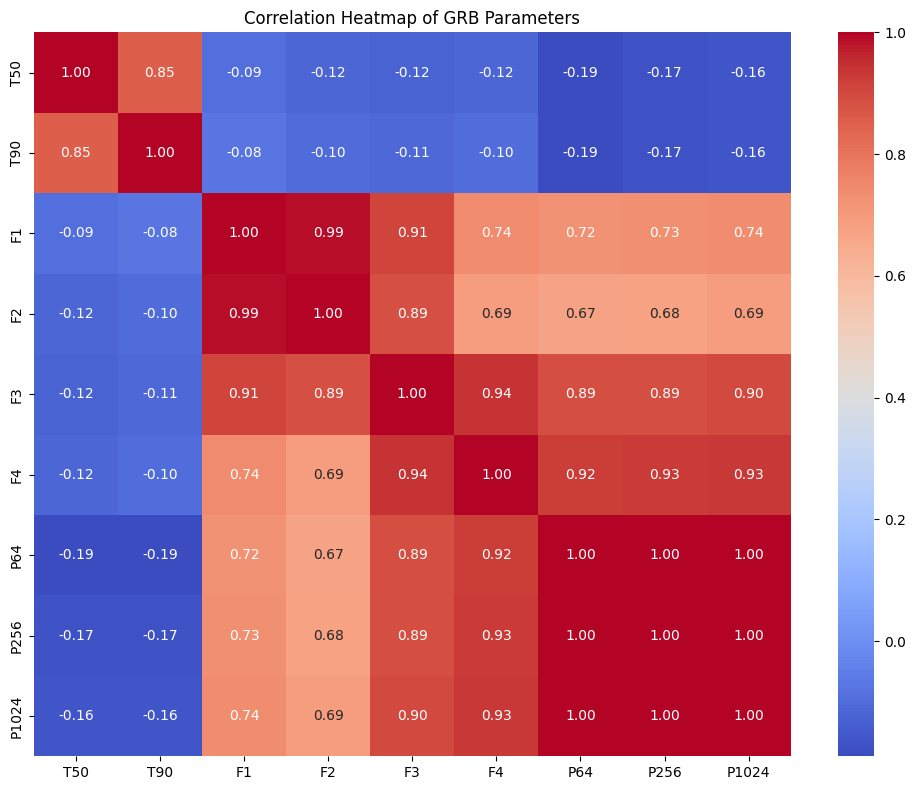

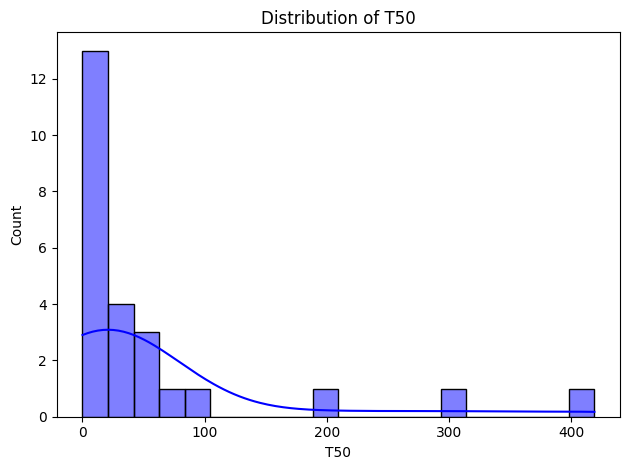

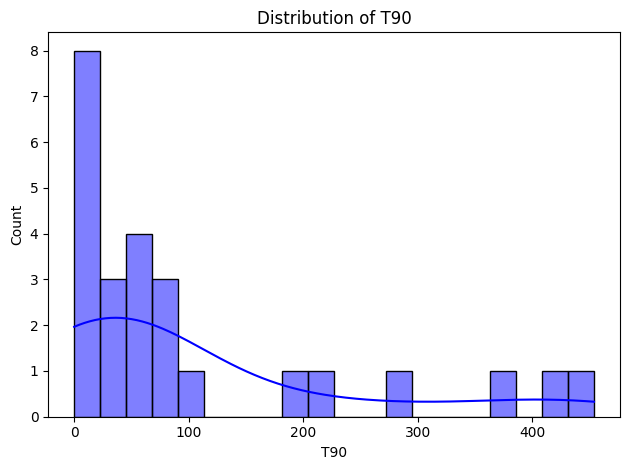

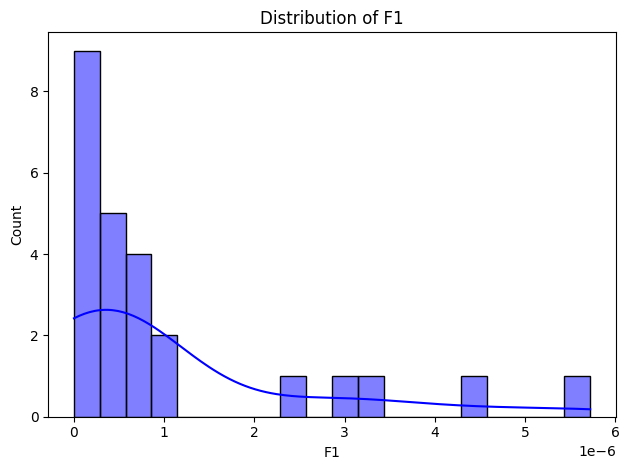

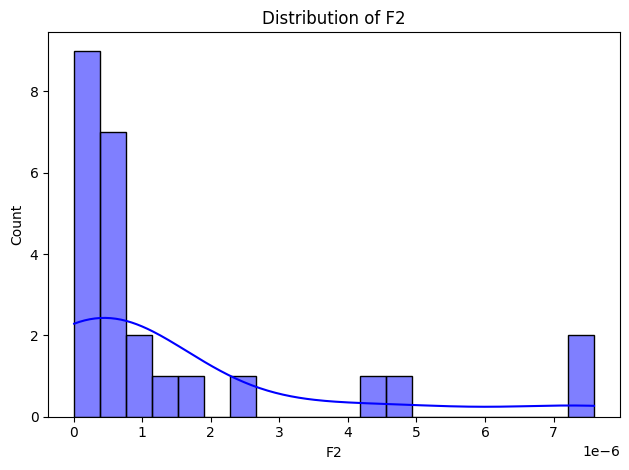

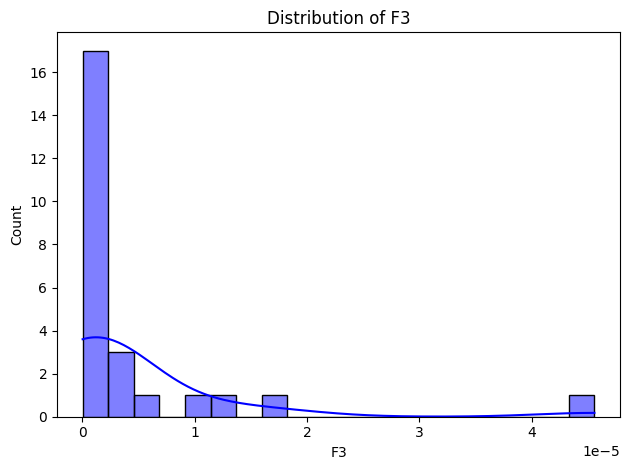

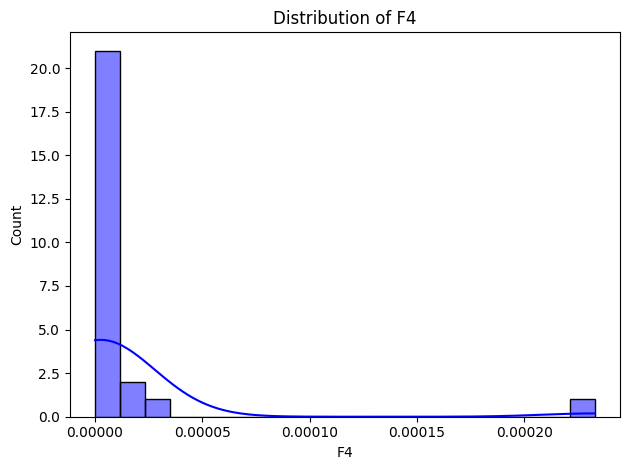

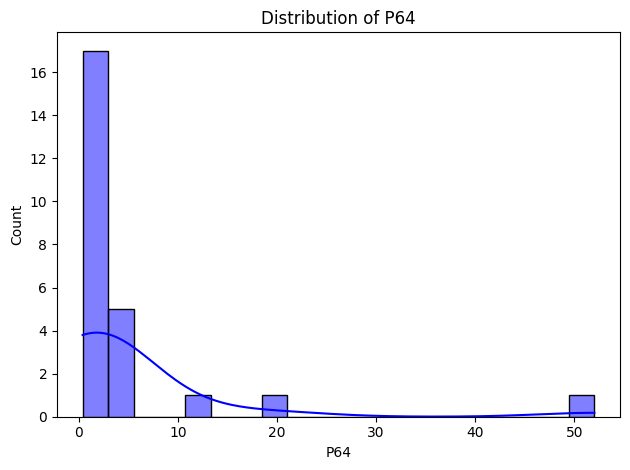

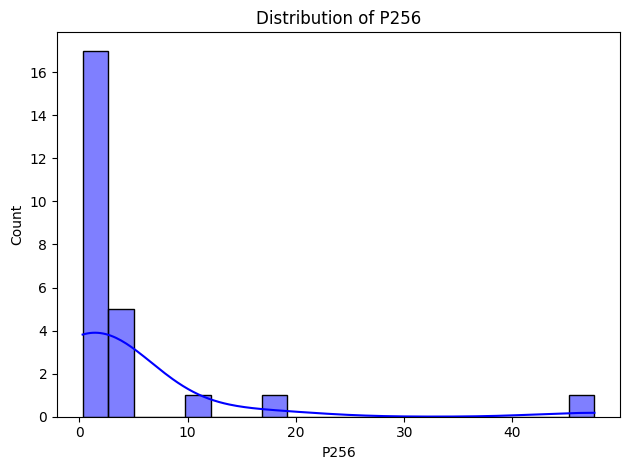

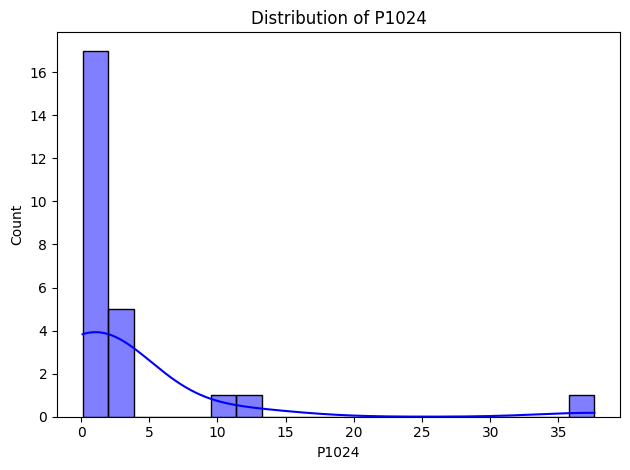

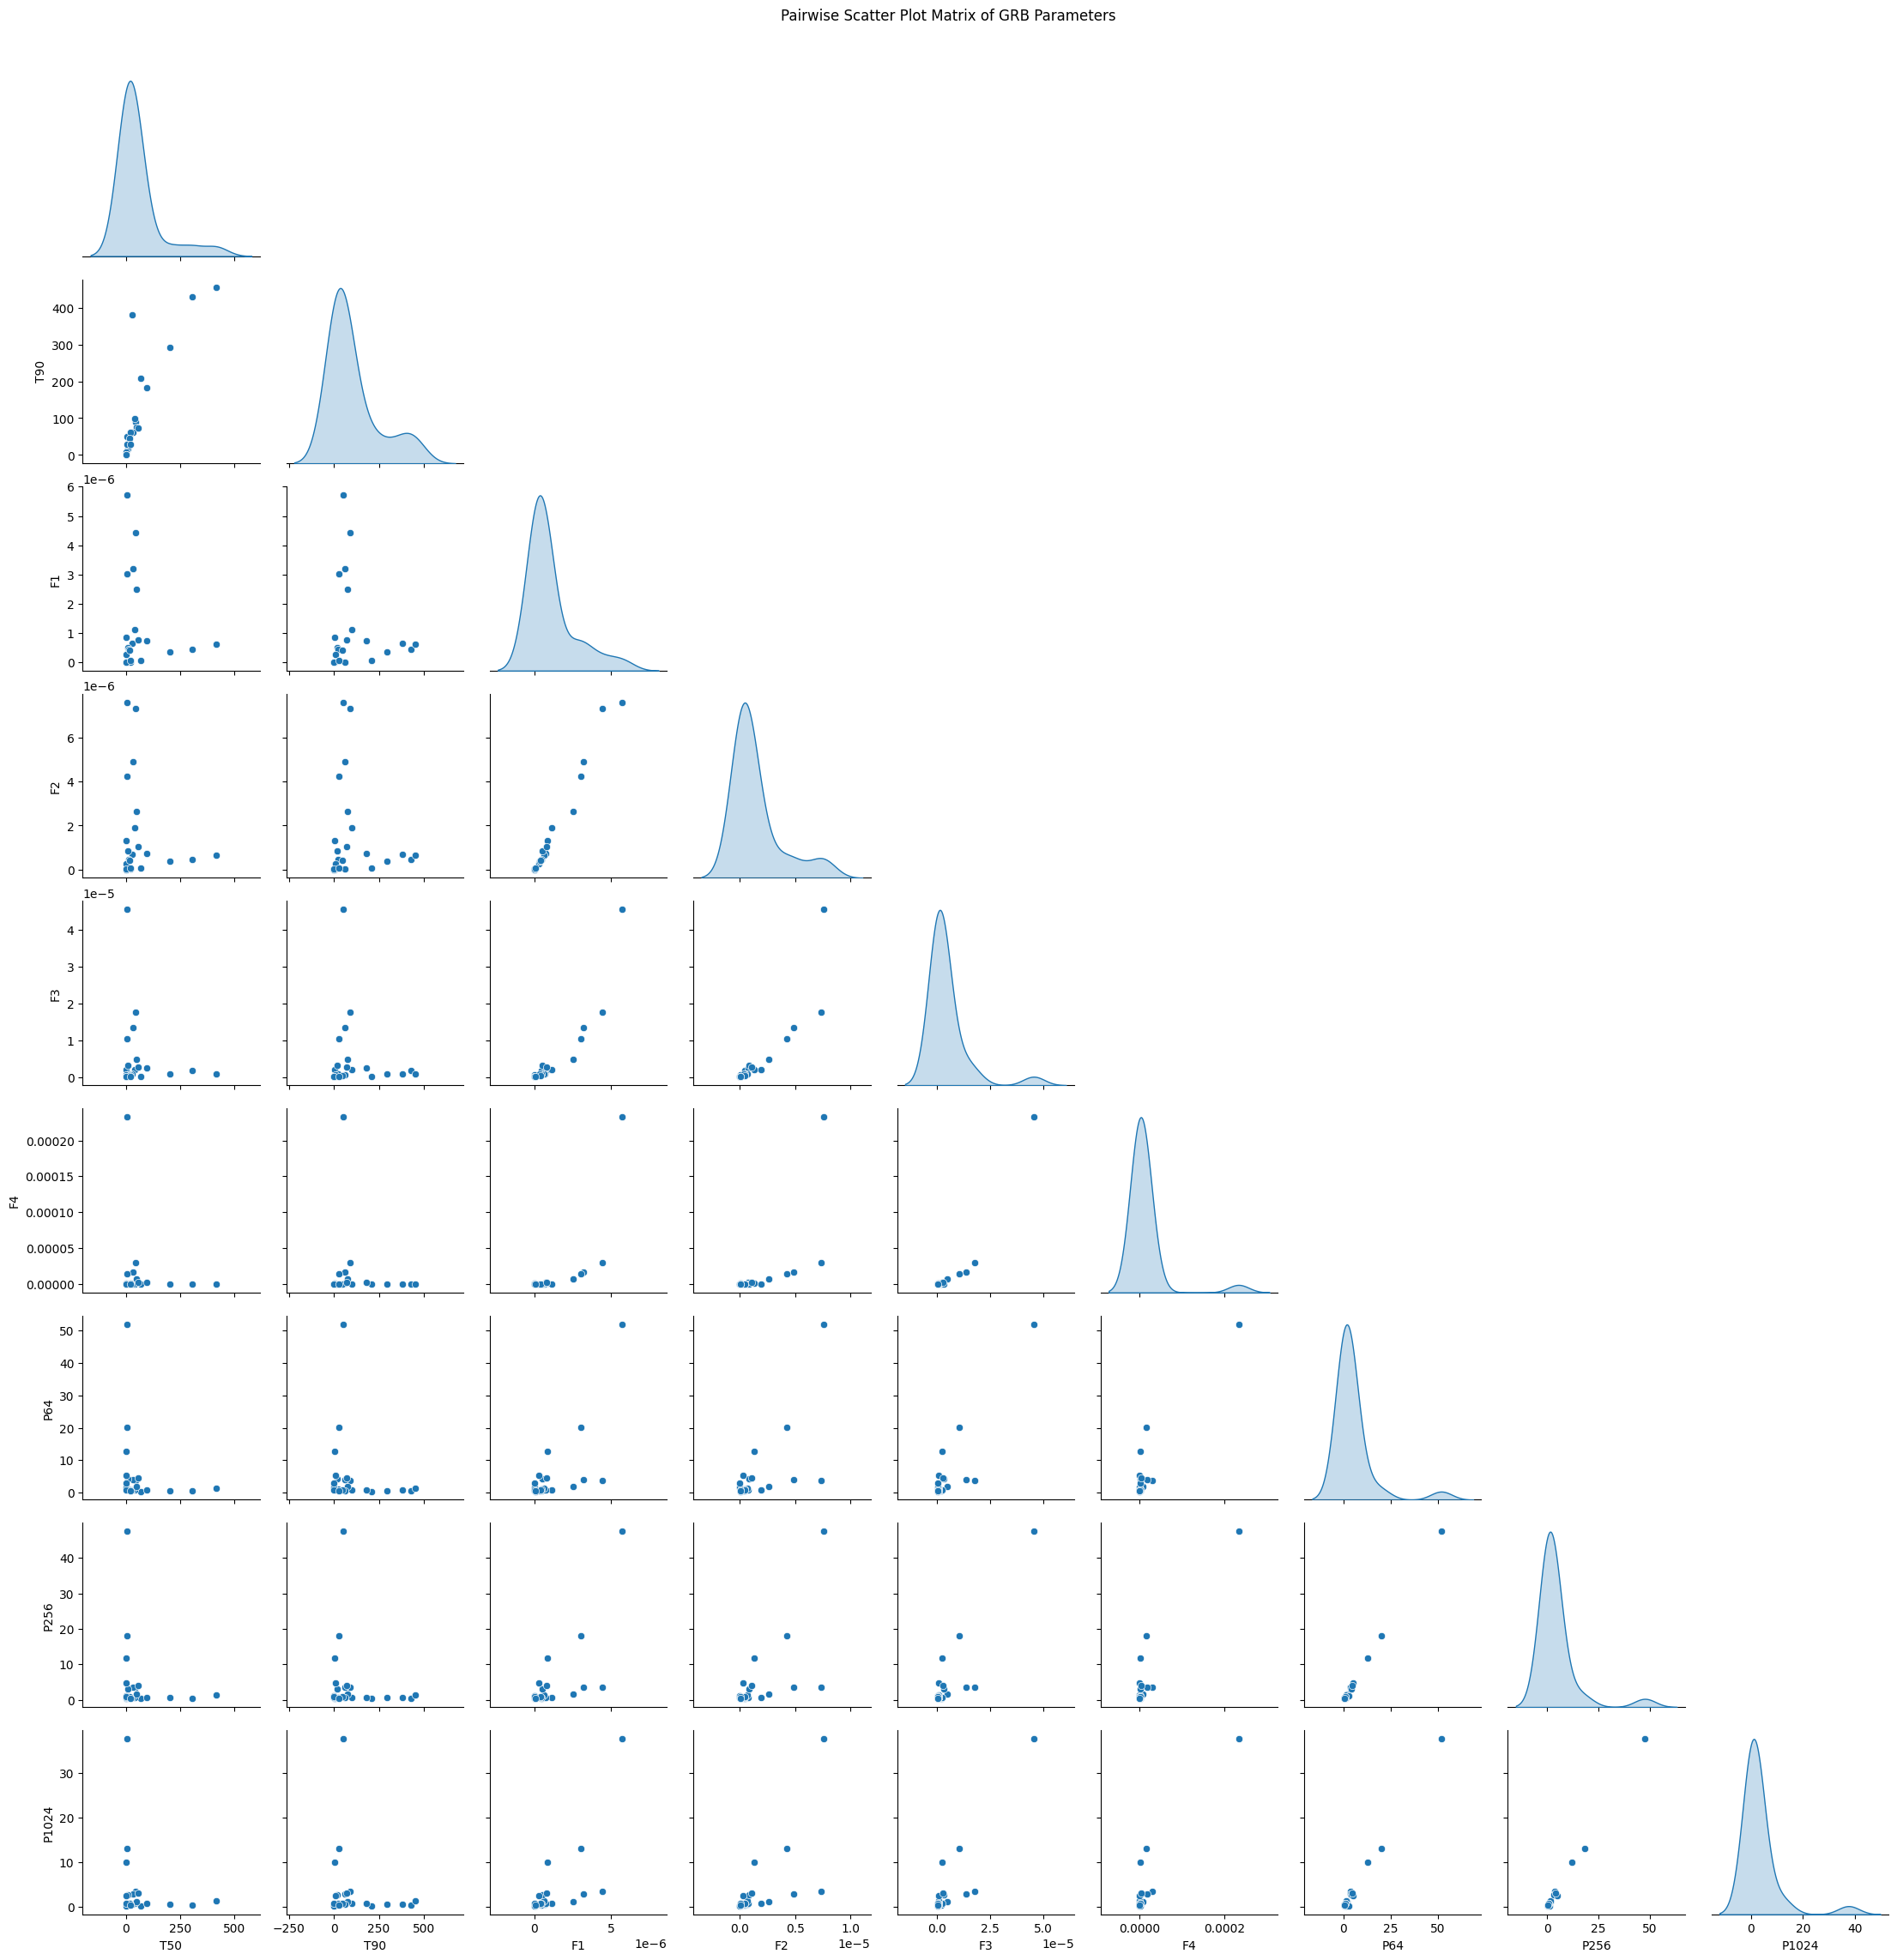

Head of DataFrame after log transform:
   TrigNo       T50       T90         F1         F2         F3         F4  \
0     105  0.583332  1.645577 -13.955808 -13.537803 -13.097622 -13.785855   
1     107  4.228409  5.340303 -16.714116 -16.680215 -16.640657 -16.379460   
2     108  0.246860  1.142948 -18.596225 -18.008571 -17.254410 -13.437006   
3     109  3.852358  4.501763 -12.327088 -11.826254 -10.941940 -10.431117   
4     110  5.724787  6.063822 -14.613796 -14.576722 -13.238841 -14.729055   

        P64      P256     P1024  
0  2.546394  2.472918  2.296265  
1 -0.896488 -1.207312 -1.609438  
2 -0.208255 -0.823256 -2.189256  
3  1.328930  1.286474  1.208960  
4 -0.744440 -0.738145 -1.002393   

Epoch [5/50] | Train Loss: 8.2003 | Val Loss: 3.1370
Epoch [10/50] | Train Loss: 8.1952 | Val Loss: 3.7863
Epoch [15/50] | Train Loss: 7.6434 | Val Loss: 4.1464
Epoch [20/50] | Train Loss: 7.3995 | Val Loss: 3.3435
Epoch [25/50] | Train Loss: 7.2088 | Val Loss: 3.5086
Epoch [30/50] | Train L

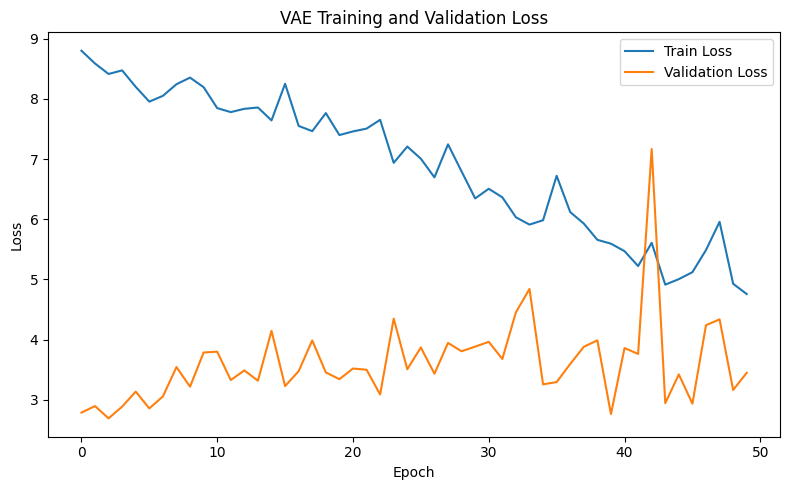

Top 5 Potential Anomalies:
    TrigNo  ReconError        z1        z2
11     143    2.253532  1.204864 -2.759683
0      105    1.208009  0.730966  0.156334
22     219    1.094144  0.028316 -2.766843
15     179    0.647611  1.811000  0.122956
19     211    0.620625 -1.057352 -0.596872 



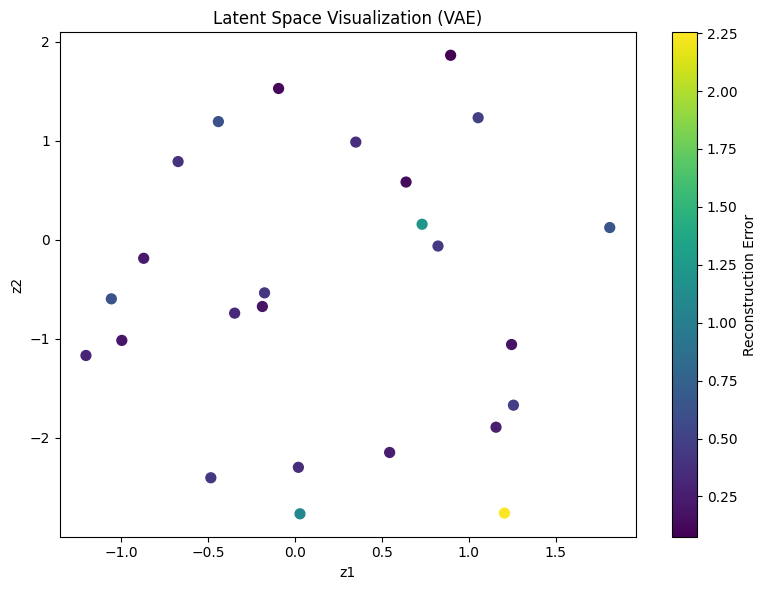

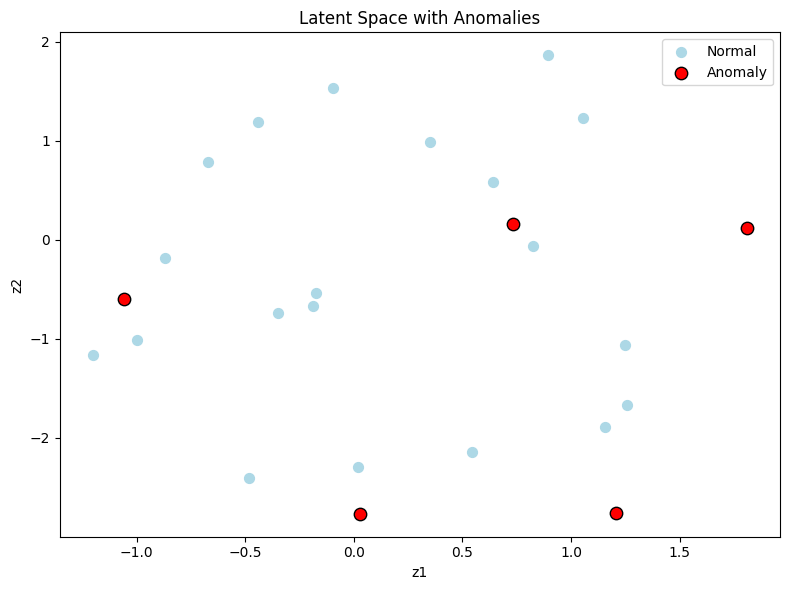

Example of Generated Synthetic GRB-like Parameters:
         T50         T90            F1            F2            F3  \
0  37.638382  106.084213  5.132910e-07  5.567370e-07  1.114763e-06   
1  11.194114   23.814842  3.214427e-08  7.256108e-08  1.820300e-07   
2  30.727161   77.994804  4.423352e-07  5.741960e-07  1.126297e-06   
3  25.610903   65.389160  4.138004e-07  7.052116e-07  1.248742e-06   
4   8.454903   21.320160  1.242951e-07  2.087380e-07  4.341002e-07   

             F4       P64      P256     P1024  
0  1.292259e-08  1.338975  1.053285  0.902953  
1  6.669048e-09  0.839484  0.631595  0.356452  
2  2.152297e-08  1.535136  1.205546  0.944146  
3  5.285465e-08  1.873832  1.474564  1.129751  
4  5.825999e-08  1.602993  1.049513  0.728239   

All results (plots, tables) have been saved in the 'results' folder.


In [ ]:
"""
Deep Variational Embedding for GRB Parameter Distributions
==========================================================

This Python script demonstrates a full pipeline to:
1. Load and preprocess BATSE GRB data (sample snippet included),
2. Perform exploratory data analysis (EDA),
3. Implement and train a Variational Autoencoder (VAE) to learn latent
   representations of the GRB parameters,
4. Generate and save plots (histograms, pairplots, correlation heatmaps,
   latent space visualization) and tables (summary statistics, anomaly detection),
   to a designated output folder for convenience.

Dependencies:
-------------
- Python 3.x
- numpy
- pandas
- matplotlib
- seaborn
- torch (PyTorch)
- sklearn

NOTE: Adjust file paths, hyperparameters, and any data-handling details as needed.
Make sure you have a GPU or suitable hardware if training on large data.
"""

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# -------------------------------------------------------------
#           1. CONFIGURATION / SETUP
# -------------------------------------------------------------

# Create output directory for plots and tables
OUTPUT_DIR = "results"
os.makedirs(OUTPUT_DIR, exist_ok=True)

# Set random seeds for reproducibility (optional)
SEED = 42
np.random.seed(SEED)
torch.manual_seed(SEED)

# Decide whether to use GPU if available
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {DEVICE}")

# -------------------------------------------------------------
#           2. LOADING & PREPROCESSING DATA
# -------------------------------------------------------------
# Below we create a small example dataframe from the snippet you provided.
# In practice, load your full dataset from a CSV or another format.
# E.g.:
#    df = pd.read_csv("your_batse_data.csv")
# Make sure the following columns exist or rename them as needed.

raw_data = {
    "TrigNo":    [105, 107, 108, 109, 110, 111, 114, 121, 130, 133, 138, 143, 148, 160, 171, 179, 185, 204, 207, 211, 214, 218, 219, 222, 223],
    "T50":       [1.792, 68.608, 1.28, 47.104, 306.368, 41.728, 29.632, 48.64, 33.792, 95.232, 0.218, 6.72, 419.008, 8.384, 12.864, 3.2, 0.056, 20.288, 0.042, 203.84, 18.816, 0.597, 6.272, 57.024, 22.784],
    "T90":       [5.184, 208.576, 3.136, 90.176, 430.016, 98.176, 381.248, 75.008, 61.952, 182.016, 0.315, 50.816, 454.016, 17.024, 24.768, 7.232, 0.132, 62.656, 0.085, 292.736, 45.696, 1.173, 29.696, 73.088, 29.184],
    "F1":        [8.69e-07, 5.50e-08, 8.29e-09, 4.43e-06, 4.50e-07, 1.11e-06, 6.59e-07, 2.50e-06, 3.19e-06, 7.43e-07, 6.71e-09, 5.72e-06, 6.31e-07, 5.17e-07, 4.34e-07, 2.57e-07, 8.57e-09, 1.47e-08, 4.09e-09, 3.66e-07, 4.06e-07, 1.12e-08, 3.03e-06, 7.81e-07, 5.18e-08],
    "F2":        [1.32e-06, 5.69e-08, 1.50e-08, 7.31e-06, 4.67e-07, 1.89e-06, 7.02e-07, 2.64e-06, 4.89e-06, 7.47e-07, 1.78e-08, 7.59e-06, 6.43e-07, 8.40e-07, 4.47e-07, 2.78e-07, 8.51e-09, 5.52e-08, 8.45e-09, 3.97e-07, 4.40e-07, 3.51e-08, 4.22e-06, 1.04e-06, 6.49e-08],
    "F3":        [2.05e-06, 5.92e-08, 3.20e-08, 1.77e-05, 1.78e-06, 2.02e-06, 7.21e-07, 4.78e-06, 1.35e-05, 2.42e-06, 5.89e-08, 4.56e-05, 8.17e-07, 3.06e-06, 7.84e-07, 5.04e-07, 3.39e-08, 5.37e-07, 5.81e-08, 7.55e-07, 4.14e-07, 1.23e-07, 1.05e-05, 2.77e-06, 1.68e-07],
    "F4":        [1.03e-06, 7.69e-08, 1.46e-06, 2.95e-05, 4.01e-07, 0,        0,        7.27e-06, 1.72e-05, 1.83e-06, 5.28e-08, 2.33e-04, 7.09e-09, 4.40e-07, 1.80e-07, 7.57e-08, 0,        1.49e-06, 3.34e-07, 0,        0,        3.49e-07, 1.48e-05, 2.54e-06, 0],
    "P64":       [12.761, 0.408, 0.812, 3.777, 0.475, 0.774, 0.74, 1.793, 3.926, 0.808, 1.107, 52.008, 1.442, 4.21, 1.077, 5.249, 1.583, 0.708, 2.836, 0.7, 0.982, 0.978, 20.133, 4.538, 0.633],
    "P256":      [11.857, 0.299, 0.439, 3.62, 0.478, 0.649, 0.722, 1.496, 3.468, 0.659, 0.722, 47.569, 1.404, 3,    0.646, 4.736, 0.729, 0.674, 1.025, 0.507, 0.752, 0.868, 18.063, 3.99, 0.457],
    "P1024":     [9.937, 0.2,   0.112, 3.35, 0.367, 0.589, 0.516, 1.128, 2.816, 0.607, 0.364, 37.634, 1.267, 2.584, 0.602, 2.5,   0.165, 0.513, 0.198, 0.466, 0.649, 0.665, 13.069, 3.005, 0.374]
}

df = pd.DataFrame(raw_data)

# (OPTIONAL) If you have the real dataset from a file, do something like:
# df = pd.read_csv('batse_grb_data.csv')

print("Initial DataFrame head:")
print(df.head(), "\n")

# -------------------------------------------------------------
#           3. EXPLORATORY DATA ANALYSIS (EDA)
# -------------------------------------------------------------

# 3.1 Summary statistics
summary_stats = df.describe().T
print("Summary Statistics:")
print(summary_stats, "\n")

# Save to CSV
summary_stats.to_csv(os.path.join(OUTPUT_DIR, "summary_statistics.csv"))

# 3.2 Pairwise correlation
corr_matrix = df.drop(columns=["TrigNo"]).corr()
print("Correlation Matrix:")
print(corr_matrix, "\n")

# 3.3 Heatmap of correlations
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Heatmap of GRB Parameters")
plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_DIR, "corr_heatmap.png"), dpi=300)
plt.show()

# 3.4 Histogram distributions of each parameter
columns_to_plot = df.drop(columns=["TrigNo"]).columns
for col in columns_to_plot:
    plt.figure()
    sns.histplot(df[col], kde=True, color="blue", bins=20)
    plt.title(f"Distribution of {col}")
    plt.xlabel(col)
    plt.ylabel("Count")
    plt.tight_layout()
    plt.savefig(os.path.join(OUTPUT_DIR, f"hist_{col}.png"), dpi=300)
    plt.show()

# 3.5 Pairplot (scatter plot matrix)
sns.pairplot(df.drop(columns=["TrigNo"]), corner=True, diag_kind="kde")
plt.suptitle("Pairwise Scatter Plot Matrix of GRB Parameters", y=1.02)
plt.savefig(os.path.join(OUTPUT_DIR, "pairplot.png"), dpi=300)
plt.show()

# -------------------------------------------------------------
#           4. DATA TRANSFORMATIONS
# -------------------------------------------------------------
# Often GRB parameters span orders of magnitude; we apply log transforms where relevant.
# We'll define which columns make sense for log transform. We'll add a small epsilon to avoid log(0).
epsilon = 1e-10
columns_for_log = ["T50","T90","F1","F2","F3","F4","P64","P256","P1024"]
df_log = df.copy()

for c in columns_for_log:
    df_log[c] = np.log(df_log[c] + epsilon)

print("Head of DataFrame after log transform:")
print(df_log.head(), "\n")

# We will store the log-transformed data in a new array for the VAE.
X = df_log[columns_for_log].values

# Scale the log data for stable training
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# -------------------------------------------------------------
#           5. PREPARE TRAIN/VAL/TEST SETS
# -------------------------------------------------------------
X_train, X_test = train_test_split(X_scaled, test_size=0.2, random_state=SEED)
X_train, X_val  = train_test_split(X_train, test_size=0.2, random_state=SEED)

# Convert to PyTorch tensors
X_train_tensor = torch.from_numpy(X_train).float()
X_val_tensor   = torch.from_numpy(X_val).float()
X_test_tensor  = torch.from_numpy(X_test).float()

train_dataset = TensorDataset(X_train_tensor)
val_dataset   = TensorDataset(X_val_tensor)
test_dataset  = TensorDataset(X_test_tensor)

BATCH_SIZE = 8
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader   = DataLoader(val_dataset,   batch_size=BATCH_SIZE, shuffle=False)
test_loader  = DataLoader(test_dataset,  batch_size=BATCH_SIZE, shuffle=False)

# -------------------------------------------------------------
#           6. DEFINE THE VAE MODEL
# -------------------------------------------------------------
class VAE(nn.Module):
    def __init__(self, input_dim=9, latent_dim=2, hidden_dims=[64, 32]):
        super(VAE, self).__init__()
        # Encoder
        encoder_layers = []
        prev_dim = input_dim
        for h_dim in hidden_dims:
            encoder_layers.append(nn.Linear(prev_dim, h_dim))
            encoder_layers.append(nn.ReLU())
            prev_dim = h_dim

        self.encoder = nn.Sequential(*encoder_layers)

        self.mu_layer = nn.Linear(prev_dim, latent_dim)
        self.logvar_layer = nn.Linear(prev_dim, latent_dim)

        # Decoder
        decoder_layers = []
        rev_hidden_dims = hidden_dims[::-1]
        prev_dim = latent_dim
        for h_dim in rev_hidden_dims:
            decoder_layers.append(nn.Linear(prev_dim, h_dim))
            decoder_layers.append(nn.ReLU())
            prev_dim = h_dim

        self.decoder = nn.Sequential(*decoder_layers)
        self.final_layer = nn.Linear(prev_dim, input_dim)

    def encode(self, x):
        h = self.encoder(x)
        mu = self.mu_layer(h)
        logvar = self.logvar_layer(h)
        return mu, logvar

    def reparameterize(self, mu, logvar):
        # logvar -> variance = exp(logvar)
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        h = self.decoder(z)
        return self.final_layer(h)

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        x_recon = self.decode(z)
        return x_recon, mu, logvar

def loss_function(x, x_recon, mu, logvar):
    # Reconstruction Loss (MSE or could use L1)
    recon_loss = nn.functional.mse_loss(x_recon, x, reduction='sum')
    # KL Divergence
    # KL = -0.5 * sum(1 + logvar - mu^2 - exp(logvar))
    kld = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return recon_loss + kld

# -------------------------------------------------------------
#           7. TRAINING THE VAE
# -------------------------------------------------------------
model = VAE(input_dim=9, latent_dim=2, hidden_dims=[64,32]).to(DEVICE)
optimizer = optim.Adam(model.parameters(), lr=1e-3)

EPOCHS = 50
train_losses = []
val_losses = []

for epoch in range(EPOCHS):
    model.train()
    epoch_train_loss = 0.0
    for batch in train_loader:
        x_batch = batch[0].to(DEVICE)
        optimizer.zero_grad()
        x_recon, mu, logvar = model(x_batch)
        loss = loss_function(x_batch, x_recon, mu, logvar)
        loss.backward()
        optimizer.step()
        epoch_train_loss += loss.item()

    epoch_train_loss /= len(train_loader.dataset)

    # Validation
    model.eval()
    epoch_val_loss = 0.0
    with torch.no_grad():
        for batch in val_loader:
            x_valb = batch[0].to(DEVICE)
            x_recon_val, mu_val, logvar_val = model(x_valb)
            val_loss = loss_function(x_valb, x_recon_val, mu_val, logvar_val)
            epoch_val_loss += val_loss.item()

    epoch_val_loss /= len(val_loader.dataset)

    train_losses.append(epoch_train_loss)
    val_losses.append(epoch_val_loss)

    if (epoch + 1) % 5 == 0:
        print(f"Epoch [{epoch+1}/{EPOCHS}] | Train Loss: {epoch_train_loss:.4f} | Val Loss: {epoch_val_loss:.4f}")

# -------------------------------------------------------------
#           8. PLOT TRAINING CURVES
# -------------------------------------------------------------
plt.figure(figsize=(8, 5))
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Validation Loss")
plt.title("VAE Training and Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_DIR, "training_curve.png"), dpi=300)
plt.show()

# -------------------------------------------------------------
#           9. ANALYZE LATENT REPRESENTATIONS & ANOMALIES
# -------------------------------------------------------------
# Obtain latent representations for entire dataset
model.eval()

with torch.no_grad():
    X_tensor = torch.from_numpy(X_scaled).float().to(DEVICE)
    x_recon, mu, logvar = model(X_tensor)
    recon_errors = torch.mean((x_recon - X_tensor)**2, dim=1)  # MSE across features
    latent_z = model.reparameterize(mu, logvar).cpu().numpy()
    recon_errors = recon_errors.cpu().numpy()

df_analysis = df.copy()
df_analysis["ReconError"] = recon_errors
df_analysis["z1"] = latent_z[:, 0]
df_analysis["z2"] = latent_z[:, 1]

# Sort by reconstruction error to identify potential anomalies
df_sorted = df_analysis.sort_values(by="ReconError", ascending=False)
print("Top 5 Potential Anomalies:")
print(df_sorted.head(5)[["TrigNo","ReconError","z1","z2"]], "\n")

# Save as CSV
df_sorted.to_csv(os.path.join(OUTPUT_DIR, "latent_and_reconstruction_errors.csv"), index=False)

# 9.1 Scatter plot in latent space, color by reconstruction error
plt.figure(figsize=(8, 6))
sc = plt.scatter(df_analysis["z1"], df_analysis["z2"], c=df_analysis["ReconError"], cmap="viridis", s=50)
plt.colorbar(sc, label="Reconstruction Error")
plt.title("Latent Space Visualization (VAE)")
plt.xlabel("z1")
plt.ylabel("z2")
plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_DIR, "latent_space.png"), dpi=300)
plt.show()

# 9.2 Highlight anomalies (top 5) in latent space
anomalies = df_sorted.head(5)
plt.figure(figsize=(8, 6))
plt.scatter(df_analysis["z1"], df_analysis["z2"], c='lightblue', s=50, label="Normal")
plt.scatter(anomalies["z1"], anomalies["z2"], c='red', edgecolors='black', s=80, label="Anomaly")
plt.title("Latent Space with Anomalies")
plt.xlabel("z1")
plt.ylabel("z2")
plt.legend()
plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_DIR, "latent_space_anomalies.png"), dpi=300)
plt.show()

# -------------------------------------------------------------
#           10. SYNTHETIC DATA GENERATION EXAMPLE
# -------------------------------------------------------------
# Sample from the prior z ~ N(0,I) and decode
SAMPLES_TO_GENERATE = 5
with torch.no_grad():
    z_samples = torch.randn(SAMPLES_TO_GENERATE, 2).to(DEVICE)
    generated_data = model.decode(z_samples)
    # Convert back from scaled+log space
    generated_data = generated_data.cpu().numpy()
    # Undo scaler
    generated_data_unscaled = scaler.inverse_transform(generated_data)
    # Undo log transform
    generated_data_exp = np.exp(generated_data_unscaled) - epsilon

gen_df = pd.DataFrame(generated_data_exp, columns=columns_for_log)
print("Example of Generated Synthetic GRB-like Parameters:")
print(gen_df, "\n")
gen_df.to_csv(os.path.join(OUTPUT_DIR, "generated_synthetic_samples.csv"), index=False)

print("All results (plots, tables) have been saved in the 'results' folder.")


Using device: cpu
Dataset loaded from BATSE-4Br-dat.csv:
   TrigNo      T50      T90            F1            F2            F3  \
0     105    1.792    5.184  8.690000e-07  1.320000e-06  2.050000e-06   
1     107   68.608  208.576  5.500000e-08  5.690000e-08  5.920000e-08   
2     108    1.280    3.136  8.290000e-09  1.500000e-08  3.200000e-08   
3     109   47.104   90.176  4.430000e-06  7.310000e-06  1.770000e-05   
4     110  306.368  430.016  4.500000e-07  4.670000e-07  1.780000e-06   

             F4     P64    P256  P1024  
0  1.030000e-06  12.761  11.857  9.937  
1  7.690000e-08   0.408   0.299  0.200  
2  1.460000e-06   0.812   0.439  0.112  
3  2.950000e-05   3.777   3.620  3.350  
4  4.010000e-07   0.475   0.478  0.367   

Initial DataFrame head:
   TrigNo      T50      T90            F1            F2            F3  \
0     105    1.792    5.184  8.690000e-07  1.320000e-06  2.050000e-06   
1     107   68.608  208.576  5.500000e-08  5.690000e-08  5.920000e-08   
2     108    

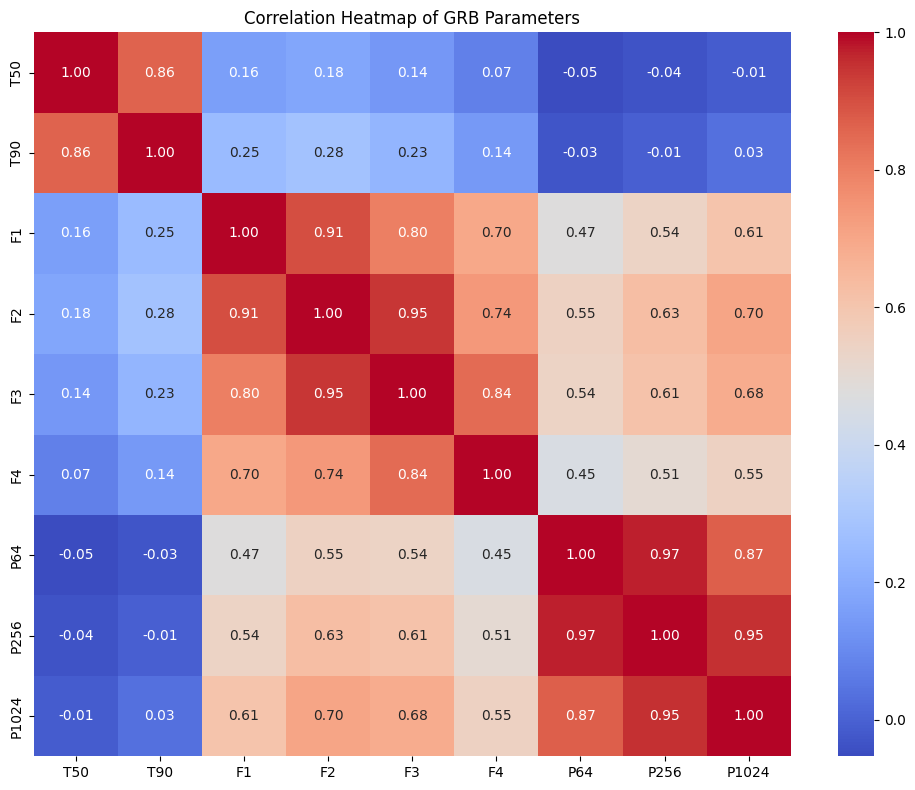

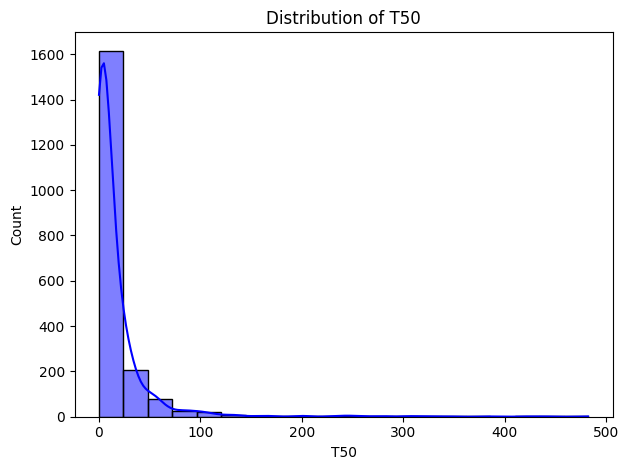

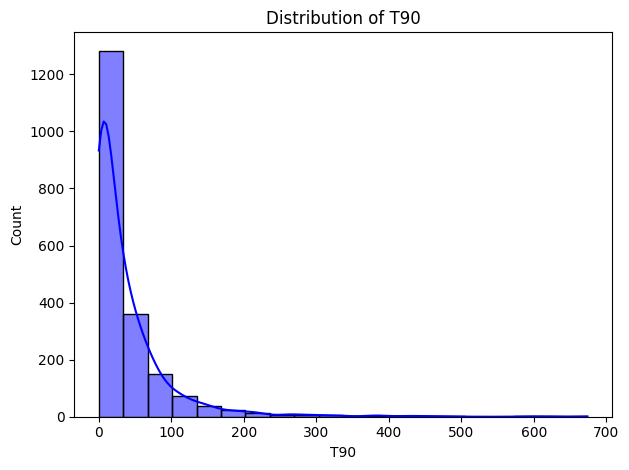

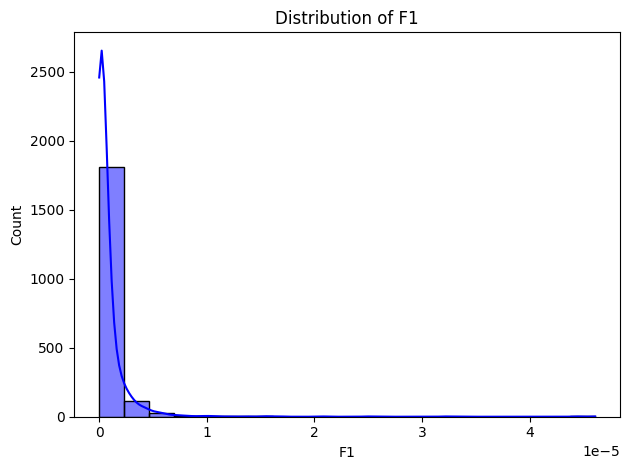

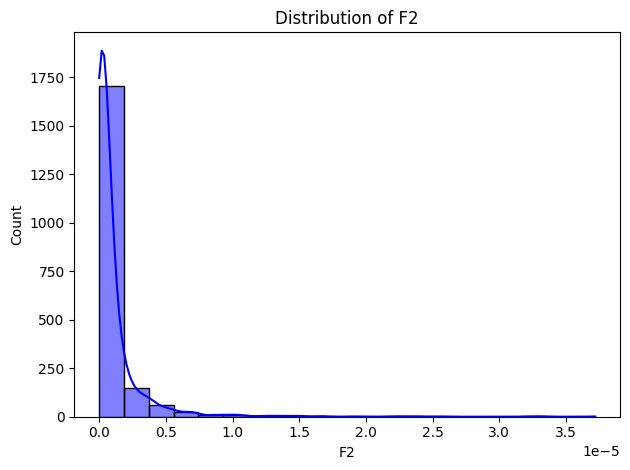

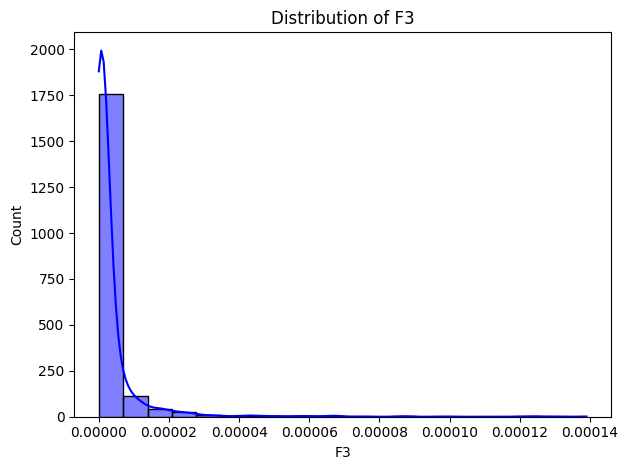

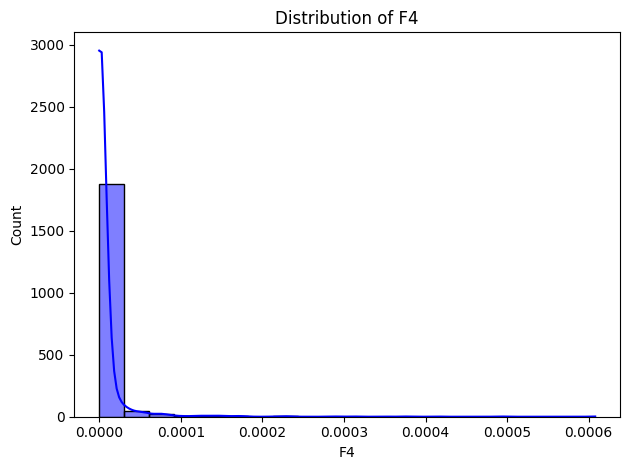

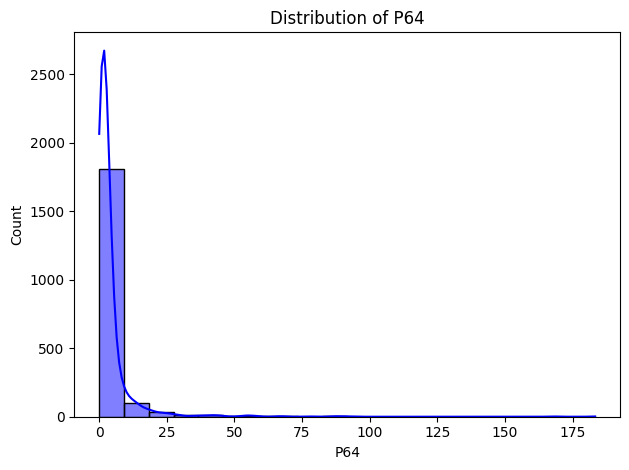

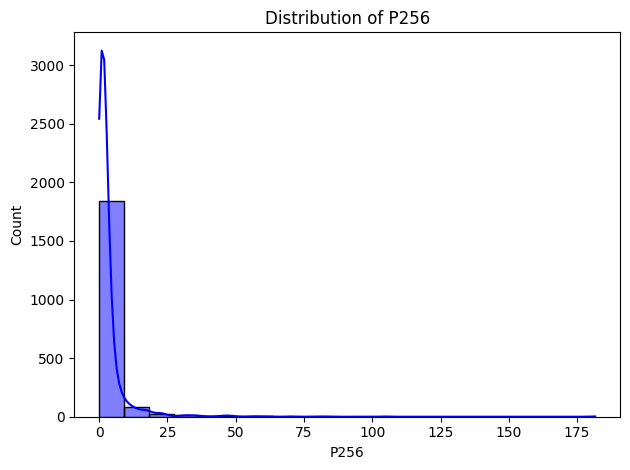

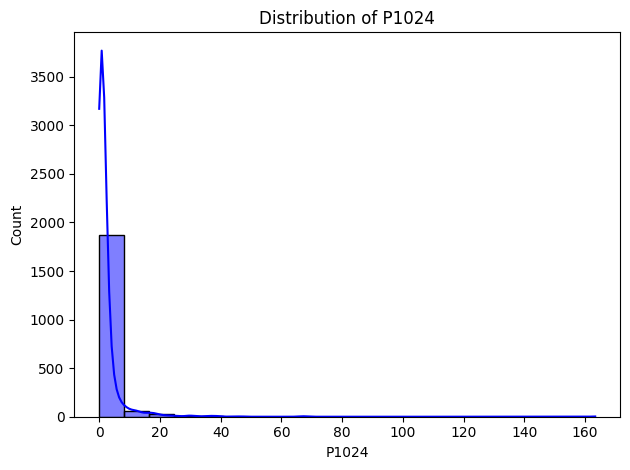

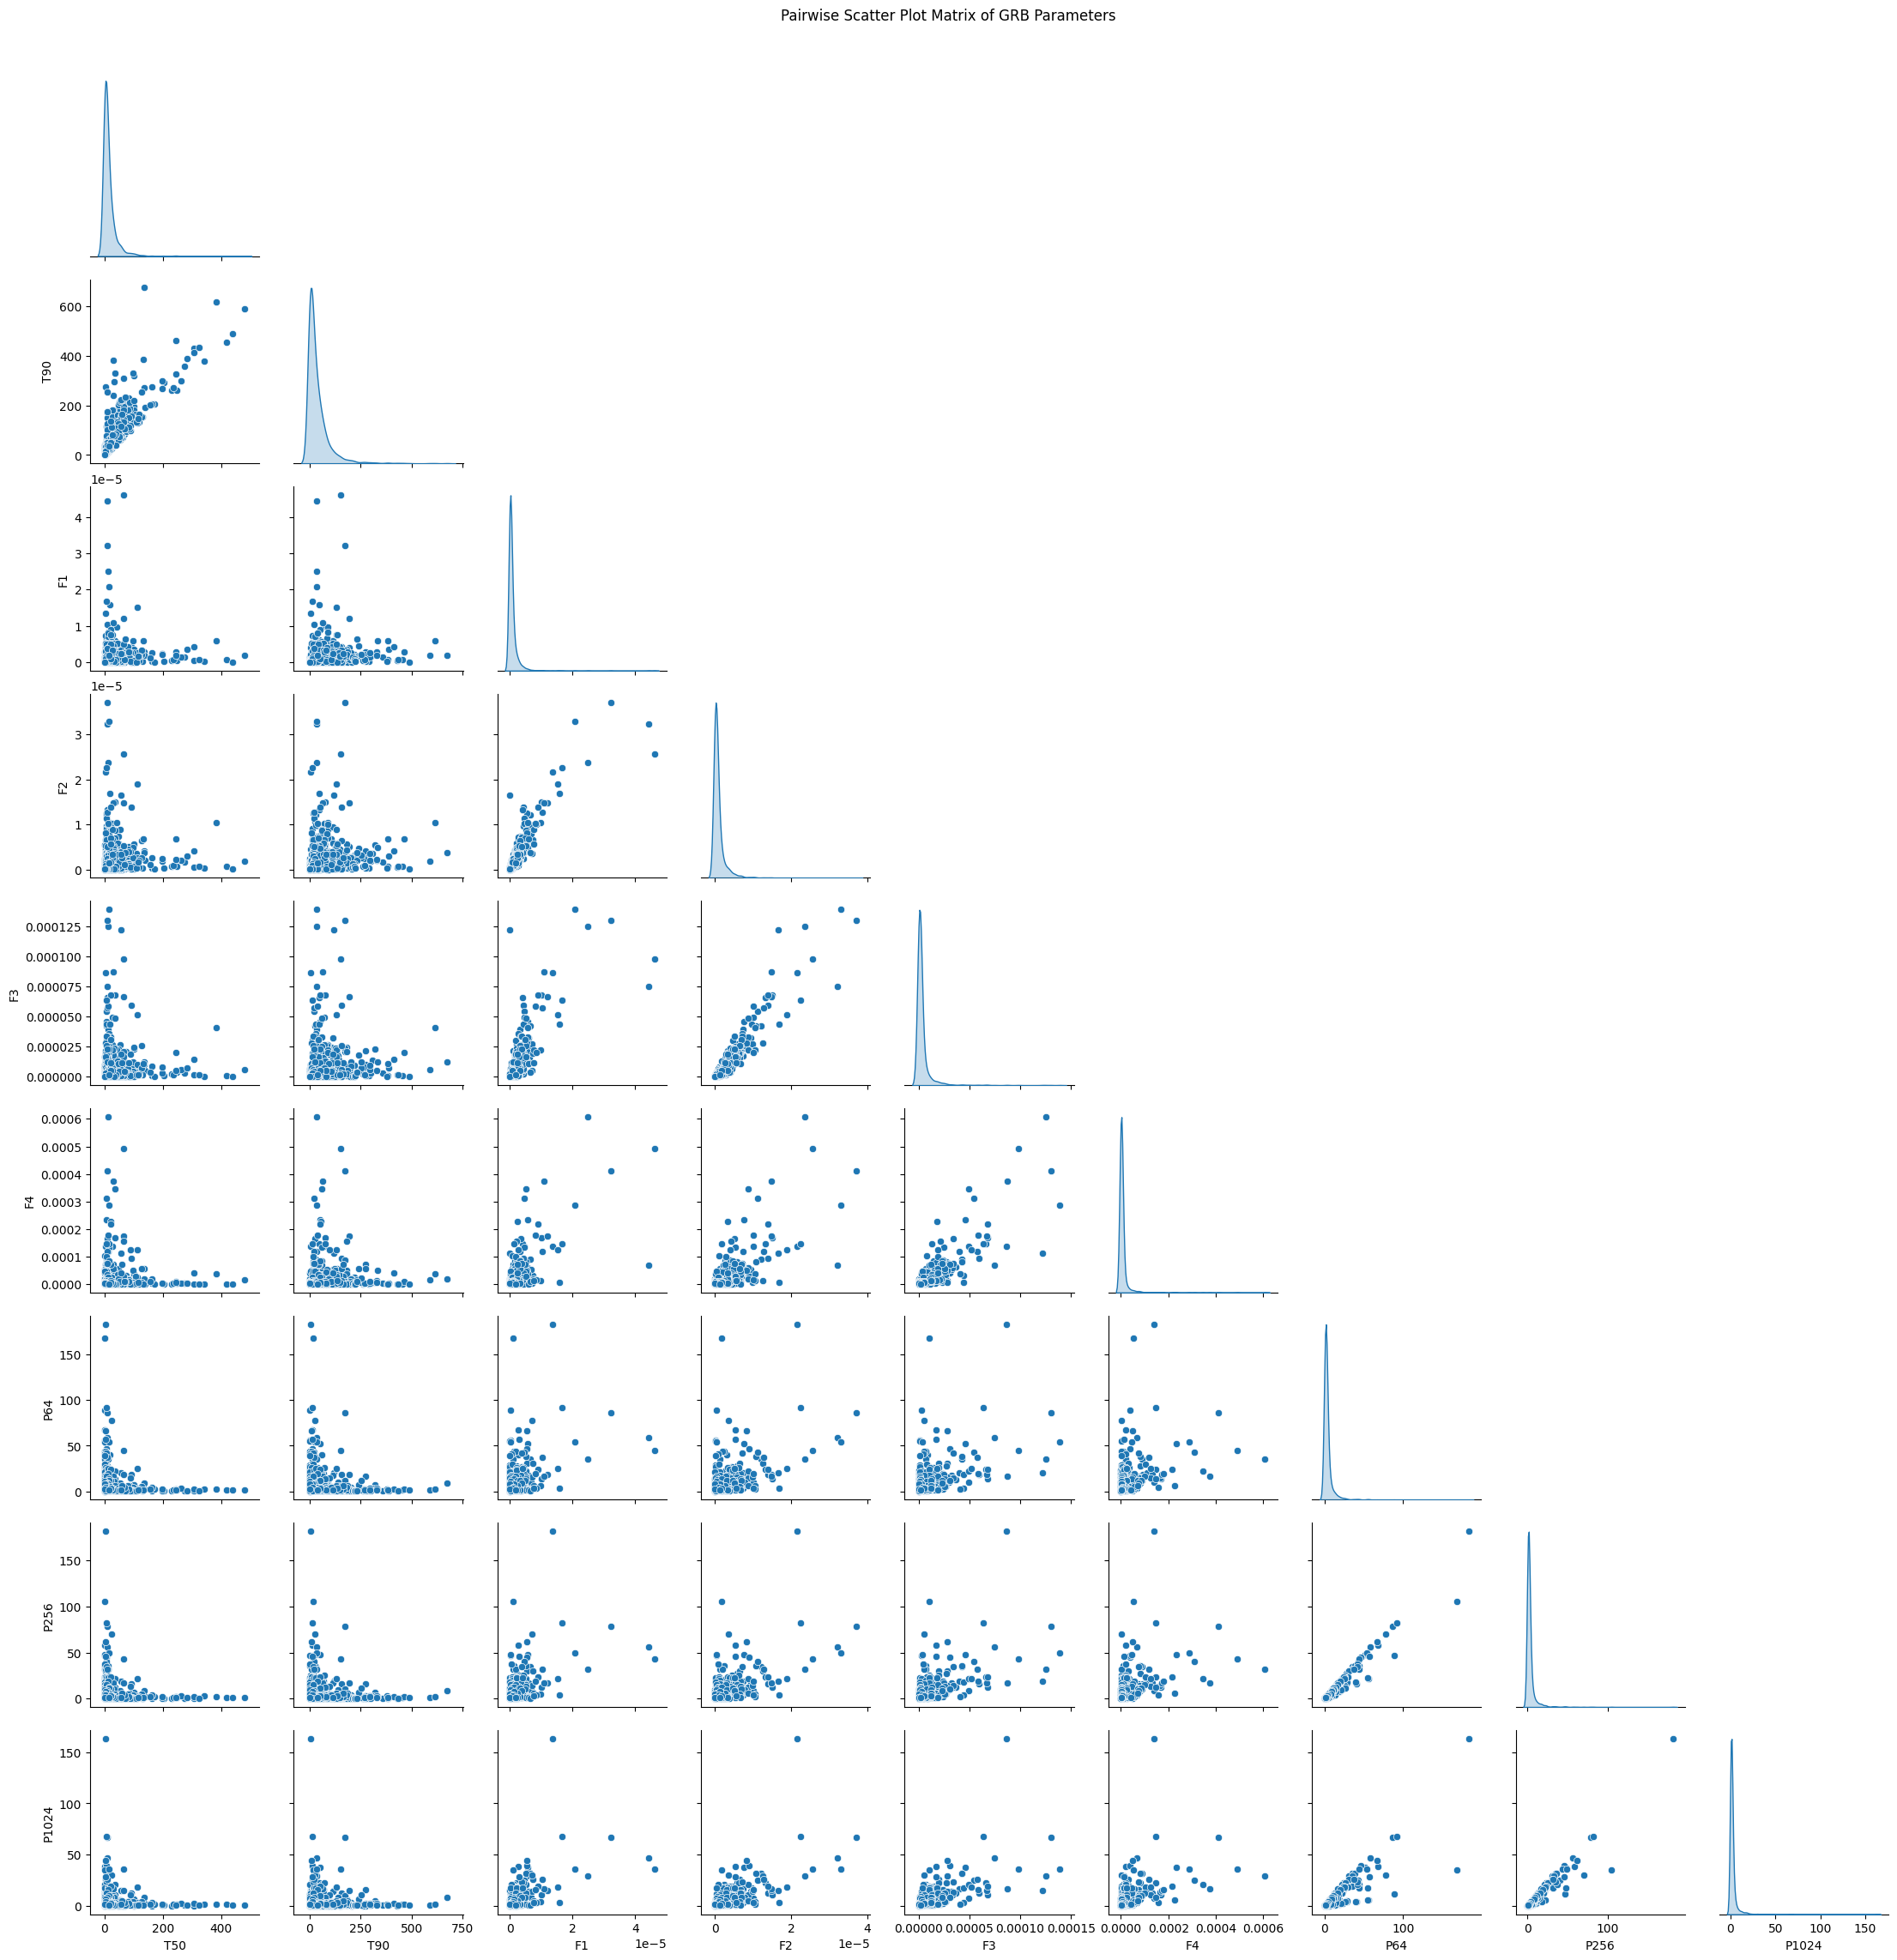

Head of DataFrame after log transform:
   TrigNo       T50       T90         F1         F2         F3         F4  \
0     105  0.583332  1.645577 -13.955808 -13.537803 -13.097622 -13.785855   
1     107  4.228409  5.340303 -16.714116 -16.680215 -16.640657 -16.379460   
2     108  0.246860  1.142948 -18.596225 -18.008571 -17.254410 -13.437006   
3     109  3.852358  4.501763 -12.327088 -11.826254 -10.941940 -10.431117   
4     110  5.724787  6.063822 -14.613796 -14.576722 -13.238841 -14.729055   

        P64      P256     P1024  
0  2.546394  2.472918  2.296265  
1 -0.896488 -1.207312 -1.609438  
2 -0.208255 -0.823256 -2.189256  
3  1.328930  1.286474  1.208960  
4 -0.744440 -0.738145 -1.002393   

Epoch [5/50] | Train Loss: 4.4338 | Val Loss: 4.0594
Epoch [10/50] | Train Loss: 4.3502 | Val Loss: 3.9690
Epoch [15/50] | Train Loss: 4.1502 | Val Loss: 3.8772
Epoch [20/50] | Train Loss: 4.1314 | Val Loss: 4.1206
Epoch [25/50] | Train Loss: 4.0415 | Val Loss: 3.7179
Epoch [30/50] | Train L

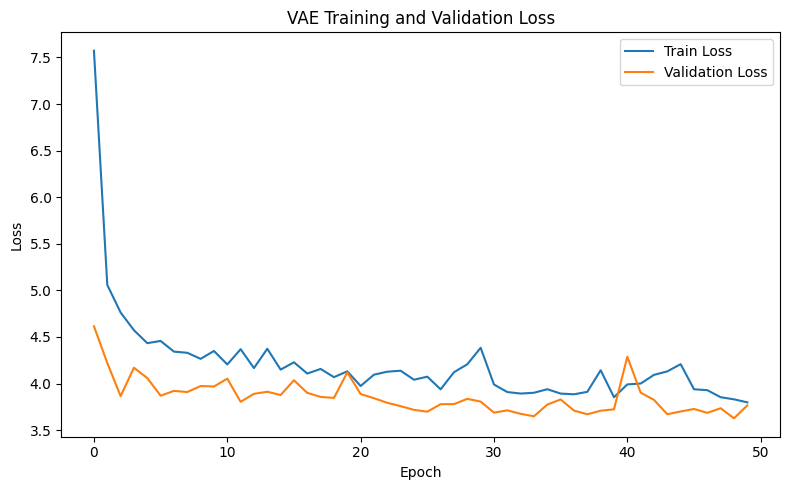

Top 5 Potential Anomalies:
     TrigNo  ReconError        z1        z2
653    2856    2.639478  0.610210 -1.809656
327    1991    2.084237 -1.310839  0.781936
487    2412    1.811972  0.517308  1.554224
97      711    1.716830 -0.543037  1.465963
668    2893    1.592130 -1.172987  1.324555 



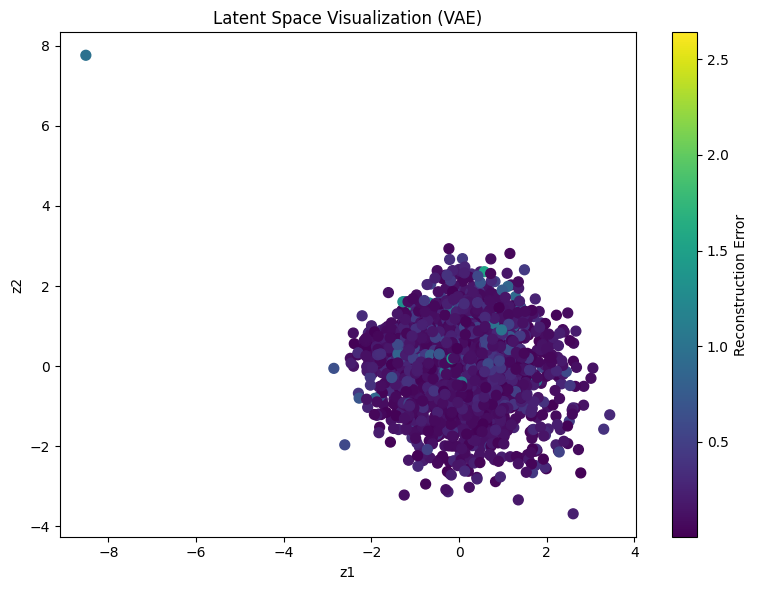

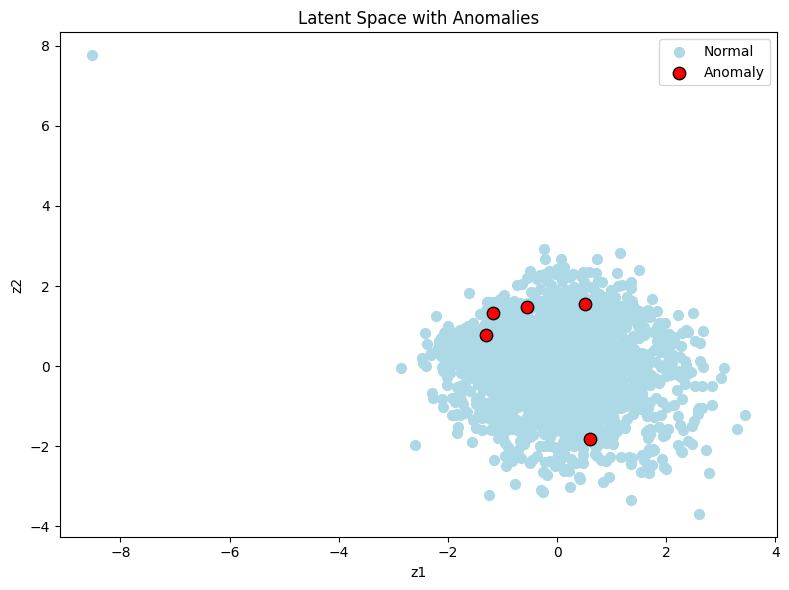

Example of Generated Synthetic GRB-like Parameters:
         T50        T90            F1            F2            F3  \
0   7.573161  25.982658  6.476052e-07  9.709223e-07  3.018567e-06   
1   4.782854  13.620738  7.900487e-08  1.095113e-07  2.859982e-07   
2   4.632857  13.155246  9.756135e-08  1.352433e-07  3.923692e-07   
3  35.967674  94.561287  7.829994e-07  1.120360e-06  2.517020e-06   
4  16.852133  45.594265  3.187869e-07  4.208709e-07  1.008374e-06   

             F4       P64      P256     P1024  
0  4.604877e-06  4.226673  3.708723  3.074189  
1  4.686616e-07  0.815770  0.666466  0.490025  
2  7.261413e-07  1.032049  0.868007  0.666411  
3  6.255687e-07  1.236150  1.045572  0.923071  
4  1.047065e-06  0.985972  0.843476  0.675604   

All results (plots, tables) have been saved in the 'results' folder.


In [ ]:
"""
Deep Variational Embedding for GRB Parameter Distributions
==========================================================

This Python script demonstrates a full pipeline to:
1. Load and preprocess BATSE GRB data (sample snippet included),
2. Perform exploratory data analysis (EDA),
3. Implement and train a Variational Autoencoder (VAE) to learn latent
   representations of the GRB parameters,
4. Generate and save plots (histograms, pairplots, correlation heatmaps,
   latent space visualization) and tables (summary statistics, anomaly detection),
   to a designated output folder for convenience.

Dependencies:
-------------
- Python 3.x
- numpy
- pandas
- matplotlib
- seaborn
- torch (PyTorch)
- sklearn

NOTE: Adjust file paths, hyperparameters, and any data-handling details as needed.
Make sure you have a GPU or suitable hardware if training on large data.
"""

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# -------------------------------------------------------------
#           1. CONFIGURATION / SETUP
# -------------------------------------------------------------

# Create output directory for plots and tables
OUTPUT_DIR = "results"
os.makedirs(OUTPUT_DIR, exist_ok=True)

# Set random seeds for reproducibility (optional)
SEED = 42
np.random.seed(SEED)
torch.manual_seed(SEED)

# Decide whether to use GPU if available
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {DEVICE}")

# -------------------------------------------------------------
#           2. LOADING & PREPROCESSING DATA
# -------------------------------------------------------------
# Below we create a small example dataframe from the snippet you provided.
# In practice, load your full dataset from a CSV or another format.
# E.g.:
#    df = pd.read_csv("your_batse_data.csv")
# Make sure the following columns exist or rename them as needed.

# Load the dataset from the CSV file
data_path = "BATSE-4Br-dat.csv"  # Replace with the actual file path
df = pd.read_csv(data_path)

# Display the first few rows of the dataset to verify
print("Dataset loaded from BATSE-4Br-dat.csv:")
print(df.head(), "\n")

# (OPTIONAL) If you have the real dataset from a file, do something like:
# df = pd.read_csv('batse_grb_data.csv')

print("Initial DataFrame head:")
print(df.head(), "\n")

# -------------------------------------------------------------
#           3. EXPLORATORY DATA ANALYSIS (EDA)
# -------------------------------------------------------------

# 3.1 Summary statistics
summary_stats = df.describe().T
print("Summary Statistics:")
print(summary_stats, "\n")

# Save to CSV
summary_stats.to_csv(os.path.join(OUTPUT_DIR, "summary_statistics.csv"))

# 3.2 Pairwise correlation
corr_matrix = df.drop(columns=["TrigNo"]).corr()
print("Correlation Matrix:")
print(corr_matrix, "\n")

# 3.3 Heatmap of correlations
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Heatmap of GRB Parameters")
plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_DIR, "corr_heatmap.png"), dpi=300)
plt.show()

# 3.4 Histogram distributions of each parameter
columns_to_plot = df.drop(columns=["TrigNo"]).columns
for col in columns_to_plot:
    plt.figure()
    sns.histplot(df[col], kde=True, color="blue", bins=20)
    plt.title(f"Distribution of {col}")
    plt.xlabel(col)
    plt.ylabel("Count")
    plt.tight_layout()
    plt.savefig(os.path.join(OUTPUT_DIR, f"hist_{col}.png"), dpi=300)
    plt.show()

# 3.5 Pairplot (scatter plot matrix)
sns.pairplot(df.drop(columns=["TrigNo"]), corner=True, diag_kind="kde")
plt.suptitle("Pairwise Scatter Plot Matrix of GRB Parameters", y=1.02)
plt.savefig(os.path.join(OUTPUT_DIR, "pairplot.png"), dpi=300)
plt.show()

# -------------------------------------------------------------
#           4. DATA TRANSFORMATIONS
# -------------------------------------------------------------
# Often GRB parameters span orders of magnitude; we apply log transforms where relevant.
# We'll define which columns make sense for log transform. We'll add a small epsilon to avoid log(0).
epsilon = 1e-10
columns_for_log = ["T50","T90","F1","F2","F3","F4","P64","P256","P1024"]
df_log = df.copy()

for c in columns_for_log:
    df_log[c] = np.log(df_log[c] + epsilon)

print("Head of DataFrame after log transform:")
print(df_log.head(), "\n")

# We will store the log-transformed data in a new array for the VAE.
X = df_log[columns_for_log].values

# Scale the log data for stable training
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# -------------------------------------------------------------
#           5. PREPARE TRAIN/VAL/TEST SETS
# -------------------------------------------------------------
X_train, X_test = train_test_split(X_scaled, test_size=0.2, random_state=SEED)
X_train, X_val  = train_test_split(X_train, test_size=0.2, random_state=SEED)

# Convert to PyTorch tensors
X_train_tensor = torch.from_numpy(X_train).float()
X_val_tensor   = torch.from_numpy(X_val).float()
X_test_tensor  = torch.from_numpy(X_test).float()

train_dataset = TensorDataset(X_train_tensor)
val_dataset   = TensorDataset(X_val_tensor)
test_dataset  = TensorDataset(X_test_tensor)

BATCH_SIZE = 8
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader   = DataLoader(val_dataset,   batch_size=BATCH_SIZE, shuffle=False)
test_loader  = DataLoader(test_dataset,  batch_size=BATCH_SIZE, shuffle=False)

# -------------------------------------------------------------
#           6. DEFINE THE VAE MODEL
# -------------------------------------------------------------
class VAE(nn.Module):
    def __init__(self, input_dim=9, latent_dim=2, hidden_dims=[64, 32]):
        super(VAE, self).__init__()
        # Encoder
        encoder_layers = []
        prev_dim = input_dim
        for h_dim in hidden_dims:
            encoder_layers.append(nn.Linear(prev_dim, h_dim))
            encoder_layers.append(nn.ReLU())
            prev_dim = h_dim

        self.encoder = nn.Sequential(*encoder_layers)

        self.mu_layer = nn.Linear(prev_dim, latent_dim)
        self.logvar_layer = nn.Linear(prev_dim, latent_dim)

        # Decoder
        decoder_layers = []
        rev_hidden_dims = hidden_dims[::-1]
        prev_dim = latent_dim
        for h_dim in rev_hidden_dims:
            decoder_layers.append(nn.Linear(prev_dim, h_dim))
            decoder_layers.append(nn.ReLU())
            prev_dim = h_dim

        self.decoder = nn.Sequential(*decoder_layers)
        self.final_layer = nn.Linear(prev_dim, input_dim)

    def encode(self, x):
        h = self.encoder(x)
        mu = self.mu_layer(h)
        logvar = self.logvar_layer(h)
        return mu, logvar

    def reparameterize(self, mu, logvar):
        # logvar -> variance = exp(logvar)
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        h = self.decoder(z)
        return self.final_layer(h)

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        x_recon = self.decode(z)
        return x_recon, mu, logvar

def loss_function(x, x_recon, mu, logvar):
    # Reconstruction Loss (MSE or could use L1)
    recon_loss = nn.functional.mse_loss(x_recon, x, reduction='sum')
    # KL Divergence
    # KL = -0.5 * sum(1 + logvar - mu^2 - exp(logvar))
    kld = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return recon_loss + kld

# -------------------------------------------------------------
#           7. TRAINING THE VAE
# -------------------------------------------------------------
model = VAE(input_dim=9, latent_dim=2, hidden_dims=[64,32]).to(DEVICE)
optimizer = optim.Adam(model.parameters(), lr=1e-3)

EPOCHS = 50
train_losses = []
val_losses = []

for epoch in range(EPOCHS):
    model.train()
    epoch_train_loss = 0.0
    for batch in train_loader:
        x_batch = batch[0].to(DEVICE)
        optimizer.zero_grad()
        x_recon, mu, logvar = model(x_batch)
        loss = loss_function(x_batch, x_recon, mu, logvar)
        loss.backward()
        optimizer.step()
        epoch_train_loss += loss.item()

    epoch_train_loss /= len(train_loader.dataset)

    # Validation
    model.eval()
    epoch_val_loss = 0.0
    with torch.no_grad():
        for batch in val_loader:
            x_valb = batch[0].to(DEVICE)
            x_recon_val, mu_val, logvar_val = model(x_valb)
            val_loss = loss_function(x_valb, x_recon_val, mu_val, logvar_val)
            epoch_val_loss += val_loss.item()

    epoch_val_loss /= len(val_loader.dataset)

    train_losses.append(epoch_train_loss)
    val_losses.append(epoch_val_loss)

    if (epoch + 1) % 5 == 0:
        print(f"Epoch [{epoch+1}/{EPOCHS}] | Train Loss: {epoch_train_loss:.4f} | Val Loss: {epoch_val_loss:.4f}")

# -------------------------------------------------------------
#           8. PLOT TRAINING CURVES
# -------------------------------------------------------------
plt.figure(figsize=(8, 5))
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Validation Loss")
plt.title("VAE Training and Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_DIR, "training_curve.png"), dpi=300)
plt.show()

# -------------------------------------------------------------
#           9. ANALYZE LATENT REPRESENTATIONS & ANOMALIES
# -------------------------------------------------------------
# Obtain latent representations for entire dataset
model.eval()

with torch.no_grad():
    X_tensor = torch.from_numpy(X_scaled).float().to(DEVICE)
    x_recon, mu, logvar = model(X_tensor)
    recon_errors = torch.mean((x_recon - X_tensor)**2, dim=1)  # MSE across features
    latent_z = model.reparameterize(mu, logvar).cpu().numpy()
    recon_errors = recon_errors.cpu().numpy()

df_analysis = df.copy()
df_analysis["ReconError"] = recon_errors
df_analysis["z1"] = latent_z[:, 0]
df_analysis["z2"] = latent_z[:, 1]

# Sort by reconstruction error to identify potential anomalies
df_sorted = df_analysis.sort_values(by="ReconError", ascending=False)
print("Top 5 Potential Anomalies:")
print(df_sorted.head(5)[["TrigNo","ReconError","z1","z2"]], "\n")

# Save as CSV
df_sorted.to_csv(os.path.join(OUTPUT_DIR, "latent_and_reconstruction_errors.csv"), index=False)

# 9.1 Scatter plot in latent space, color by reconstruction error
plt.figure(figsize=(8, 6))
sc = plt.scatter(df_analysis["z1"], df_analysis["z2"], c=df_analysis["ReconError"], cmap="viridis", s=50)
plt.colorbar(sc, label="Reconstruction Error")
plt.title("Latent Space Visualization (VAE)")
plt.xlabel("z1")
plt.ylabel("z2")
plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_DIR, "latent_space.png"), dpi=300)
plt.show()

# 9.2 Highlight anomalies (top 5) in latent space
anomalies = df_sorted.head(5)
plt.figure(figsize=(8, 6))
plt.scatter(df_analysis["z1"], df_analysis["z2"], c='lightblue', s=50, label="Normal")
plt.scatter(anomalies["z1"], anomalies["z2"], c='red', edgecolors='black', s=80, label="Anomaly")
plt.title("Latent Space with Anomalies")
plt.xlabel("z1")
plt.ylabel("z2")
plt.legend()
plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_DIR, "latent_space_anomalies.png"), dpi=300)
plt.show()

# -------------------------------------------------------------
#           10. SYNTHETIC DATA GENERATION EXAMPLE
# -------------------------------------------------------------
# Sample from the prior z ~ N(0,I) and decode
SAMPLES_TO_GENERATE = 5
with torch.no_grad():
    z_samples = torch.randn(SAMPLES_TO_GENERATE, 2).to(DEVICE)
    generated_data = model.decode(z_samples)
    # Convert back from scaled+log space
    generated_data = generated_data.cpu().numpy()
    # Undo scaler
    generated_data_unscaled = scaler.inverse_transform(generated_data)
    # Undo log transform
    generated_data_exp = np.exp(generated_data_unscaled) - epsilon

gen_df = pd.DataFrame(generated_data_exp, columns=columns_for_log)
print("Example of Generated Synthetic GRB-like Parameters:")
print(gen_df, "\n")
gen_df.to_csv(os.path.join(OUTPUT_DIR, "generated_synthetic_samples.csv"), index=False)

print("All results (plots, tables) have been saved in the 'results' folder.")


Using device: cpu
Dataset loaded from BATSE-4Br-dat.csv:
   TrigNo      T50      T90            F1            F2            F3  \
0     105    1.792    5.184  8.690000e-07  1.320000e-06  2.050000e-06   
1     107   68.608  208.576  5.500000e-08  5.690000e-08  5.920000e-08   
2     108    1.280    3.136  8.290000e-09  1.500000e-08  3.200000e-08   
3     109   47.104   90.176  4.430000e-06  7.310000e-06  1.770000e-05   
4     110  306.368  430.016  4.500000e-07  4.670000e-07  1.780000e-06   

             F4     P64    P256  P1024  
0  1.030000e-06  12.761  11.857  9.937  
1  7.690000e-08   0.408   0.299  0.200  
2  1.460000e-06   0.812   0.439  0.112  
3  2.950000e-05   3.777   3.620  3.350  
4  4.010000e-07   0.475   0.478  0.367   

DataFrame Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1973 entries, 0 to 1972
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   TrigNo  1973 non-null   int64  
 1   T50     1973 non-

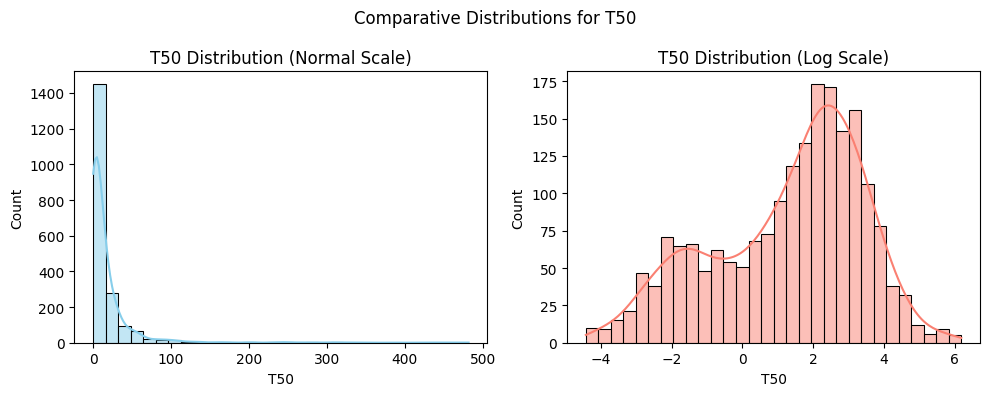

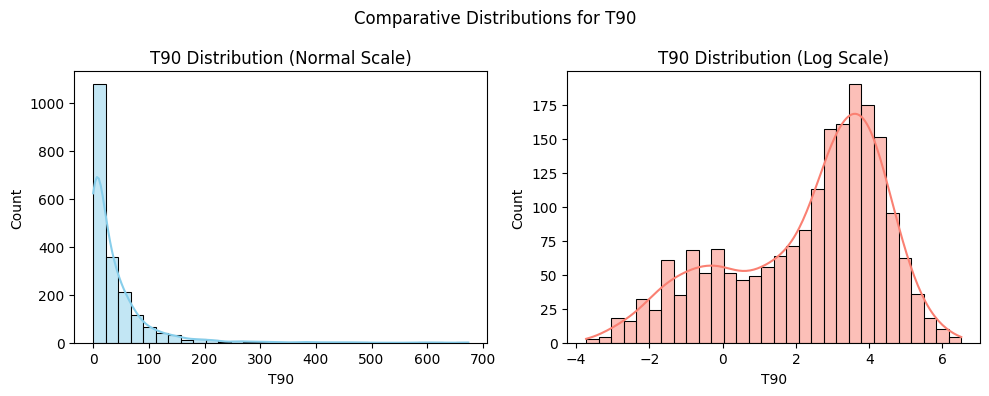

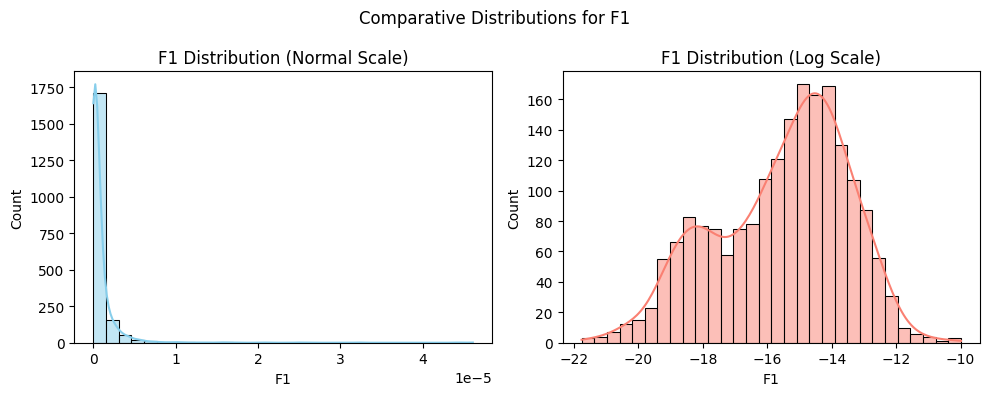

Shape of dataset for VAE after dropping NaNs: (1973, 10)
Epoch [5/50] | Train Loss: 5.0190 | Val Loss: 4.4032
Epoch [10/50] | Train Loss: 4.4294 | Val Loss: 3.9846
Epoch [15/50] | Train Loss: 3.3608 | Val Loss: 3.0955
Epoch [20/50] | Train Loss: 2.9710 | Val Loss: 2.7119
Epoch [25/50] | Train Loss: 2.8309 | Val Loss: 2.6101
Epoch [30/50] | Train Loss: 2.7697 | Val Loss: 2.4640
Epoch [35/50] | Train Loss: 2.6771 | Val Loss: 2.3142
Epoch [40/50] | Train Loss: 2.6179 | Val Loss: 2.4557
Epoch [45/50] | Train Loss: 2.5915 | Val Loss: 2.5319
Epoch [50/50] | Train Loss: 2.6322 | Val Loss: 2.4000


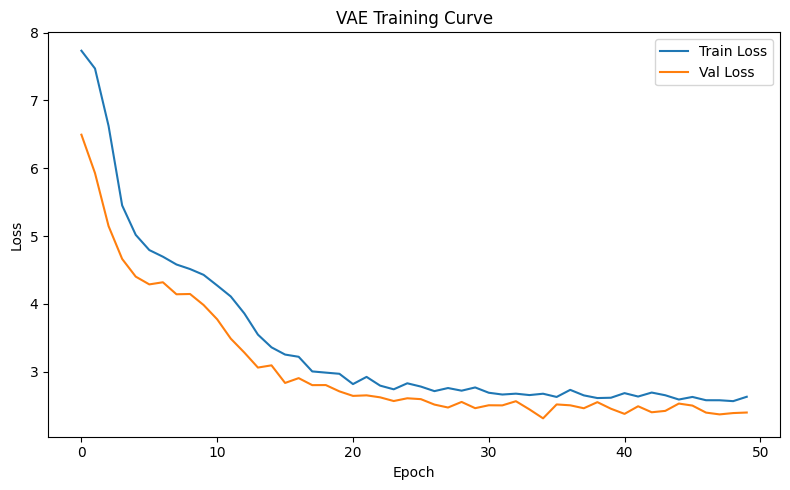

Test Set Loss: 3.3774
Top 5 Potential Anomalies based on Reconstruction Error:
      ReconError     T50      T90        F1        F2        F3        F4  \
1208   20.153072   2.176    5.312  0.000014  0.000022  0.000087  0.000138   
1045   16.057915   8.384   36.480  0.000044  0.000032  0.000075  0.000069   
742    10.898869  13.376   34.880  0.000025  0.000024  0.000125  0.000608   
653     9.375995  56.512  119.872  0.000000  0.000017  0.000122  0.000111   
919     5.854143  35.584   59.072  0.000005  0.000009  0.000049  0.000346   

          P64     P256    P1024  
1208  183.370  181.634  163.344  
1045   58.604   56.226   46.868  
742    35.100   32.364   29.515  
653    20.045   18.633   14.817  
919    21.806   21.568   20.696   



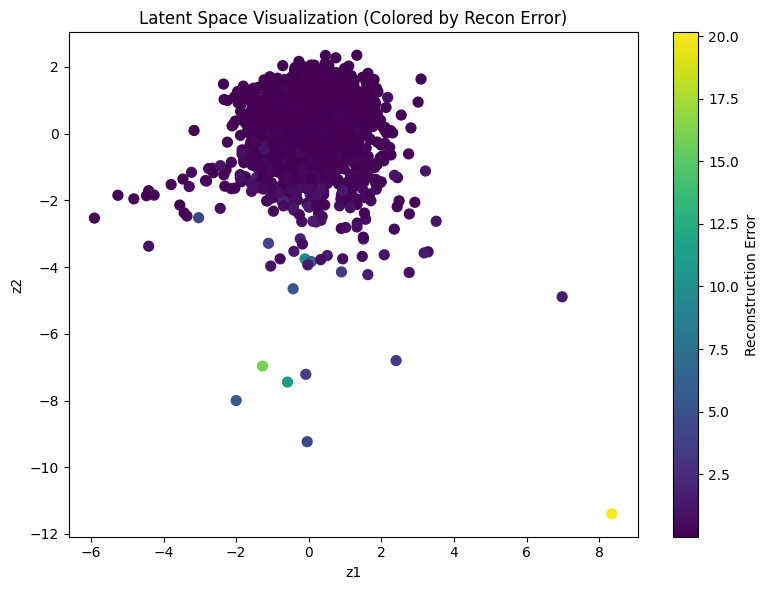

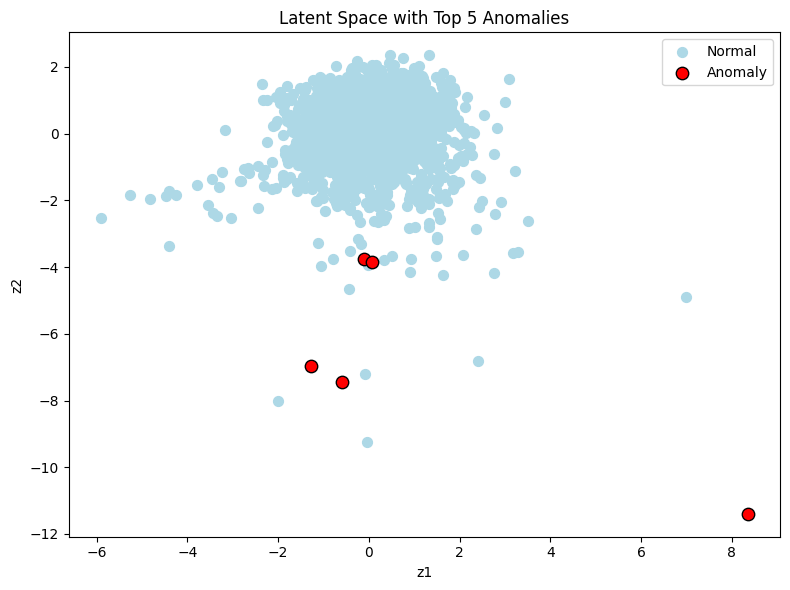

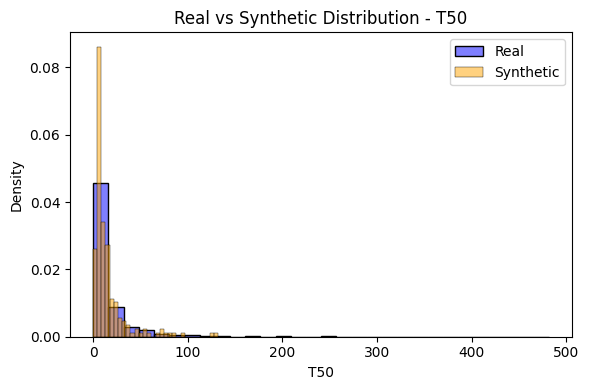

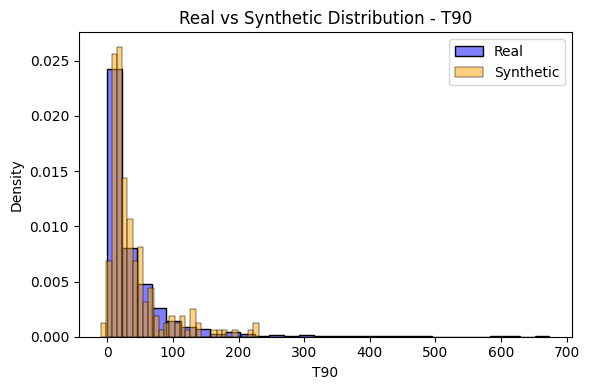

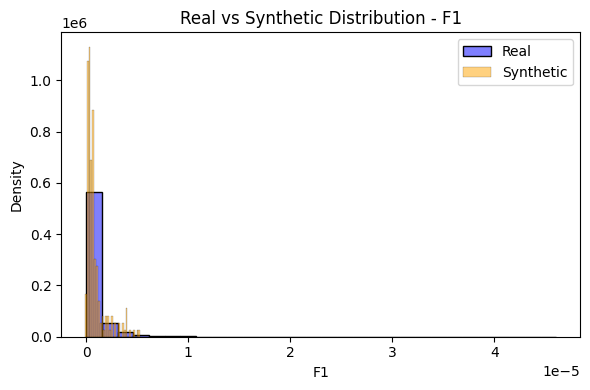

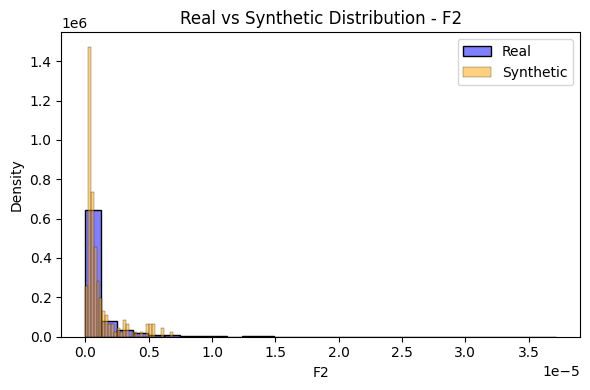

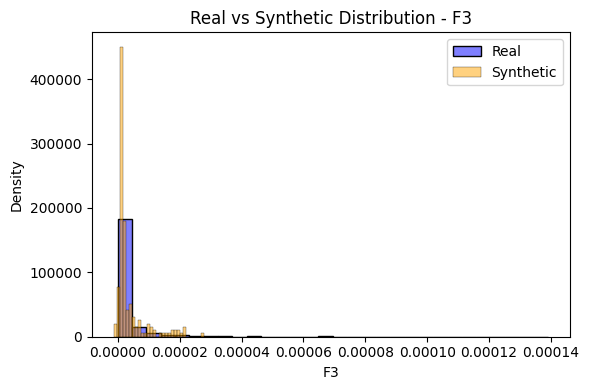

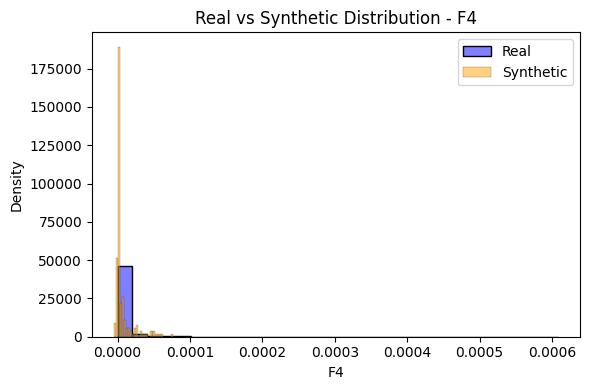

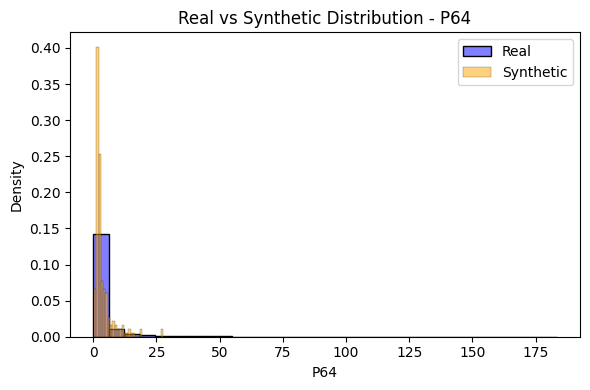

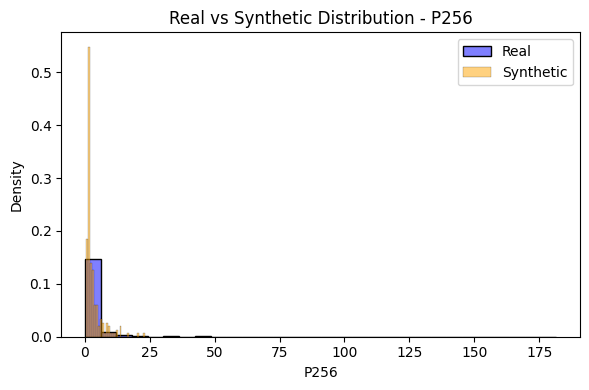

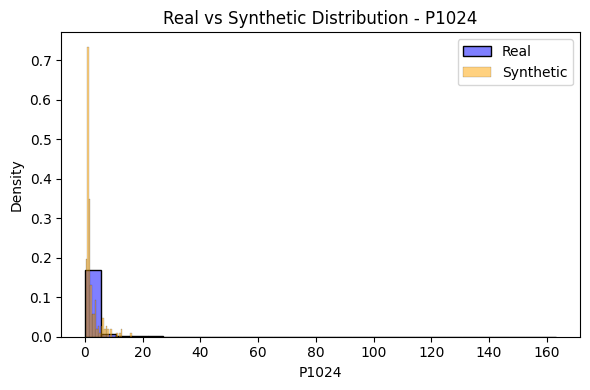

Real Data Cluster Counts (K=2): [1385  588]
Synthetic Data Cluster Counts (K=2): [133  67]


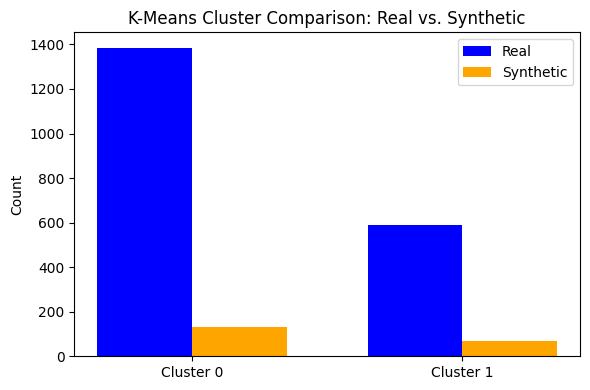

All requested plots and tables have been saved in the 'results' folder.
Pipeline complete. You can review the figures for distributions, anomalies, latent spaces, and more.


In [ ]:
"""
Deep Variational Embedding for GRB Parameter Distributions
==========================================================

This Python script demonstrates a full pipeline to:
  1. Load and preprocess BATSE GRB data from a CSV file ("BATSE-4Br-dat.csv"),
  2. Perform exploratory data analysis (EDA),
  3. Implement and train a Variational Autoencoder (VAE) to learn latent
     representations of the GRB parameters,
  4. Generate overlapping distribution plots (in both normal and log scales),
  5. Generate synthetic GRB data via the trained VAE and compare its distribution
     to the real dataset,
  6. Provide a simple clustering-based check (e.g., KMeans) to see if synthetic
     data are classified similarly to real data,
  7. Identify anomalies and visualize them in the latent space,
  8. Save all important plots and tables to a designated folder.

Dependencies:
-------------
- Python 3.x
- numpy
- pandas
- matplotlib
- seaborn
- scikit-learn
- torch (PyTorch)
- tqdm (for a nicer progress bar, optional)

Please adapt paths, hyperparameters, and column names to match your environment.
"""

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

# -------------------------------------------------------------
# 1. Configuration / Setup
# -------------------------------------------------------------
OUTPUT_DIR = "results"
os.makedirs(OUTPUT_DIR, exist_ok=True)

SEED = 42
np.random.seed(SEED)
torch.manual_seed(SEED)

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {DEVICE}")

# -------------------------------------------------------------
# 2. Load the dataset from the CSV file
# -------------------------------------------------------------
data_path = "BATSE-4Br-dat.csv"  # Replace with your actual file path
df = pd.read_csv(data_path)

print("Dataset loaded from BATSE-4Br-dat.csv:")
print(df.head(), "\n")

# -------------------------------------------------------------
# 3. Exploratory Data Analysis (EDA)
# -------------------------------------------------------------
#    3.1 Basic summary
print("DataFrame Info:")
print(df.info(), "\n")

print("Summary Statistics:")
summary_stats = df.describe().T
print(summary_stats, "\n")
summary_stats.to_csv(os.path.join(OUTPUT_DIR, "summary_stats.csv"))

# Identify numeric columns (excluding indexes/IDs if needed)
# Adjust to match the actual relevant columns in your dataset.
# E.g., let's assume these columns exist in your CSV. If not, rename accordingly.
# columns_to_explore = ["T50", "T90", "F1", "F2", "F3", "F4", "P64", "P256", "P1024"]
# If you have different or additional columns, update below:

numeric_columns = df.select_dtypes(include=[np.number]).columns.tolist()
print(f"Numeric columns found: {numeric_columns}")

#    3.2 Overlapping distribution plots for a few parameters
#        We'll pick a few as examples, say T50, T90, F1.
#        We'll do a normal-scale hist overlayed with a log-scale hist on the same figure.
columns_for_demo = ["T50", "T90", "F1"]  # Adjust as needed

for col in columns_for_demo:
    if col in numeric_columns:
        fig, ax = plt.subplots(1, 2, figsize=(10,4))

        # Left plot: normal scale
        sns.histplot(df[col], ax=ax[0], kde=True, color="skyblue", bins=30)
        ax[0].set_title(f"{col} Distribution (Normal Scale)")

        # Right plot: log scale on X-axis
        # We'll only plot for values > 0 to avoid log of non-positive
        valid_data = df[col][df[col] > 0]
        sns.histplot(np.log(valid_data), ax=ax[1], kde=True, color="salmon", bins=30)
        ax[1].set_title(f"{col} Distribution (Log Scale)")

        fig.suptitle(f"Comparative Distributions for {col}")
        plt.tight_layout()
        plt.savefig(os.path.join(OUTPUT_DIR, f"{col}_overlapping_distribution.png"), dpi=300)
        plt.show()

# -------------------------------------------------------------
# 4. Prepare data for VAE
#    Decide on columns to include in your model
#    (e.g., T50, T90, F1, F2, F3, F4, P64, P256, P1024).
# -------------------------------------------------------------
# Filter out any non-numeric or ID columns.
# Adjust columns as appropriate for your data schema:
vae_columns = ["T50","T90","F1","F2","F3","F4","P64","P256","P1024"]
vae_columns = [c for c in vae_columns if c in numeric_columns]

# Drop rows with NaN or invalid data if necessary
df_model = df.dropna(subset=vae_columns).copy()
print(f"Shape of dataset for VAE after dropping NaNs: {df_model.shape}")

# We'll keep the data as-is (centered near zero),
# but also create a log version to see if that helps.
# In practice, you might want to do either approach or experiment with both.

X_raw = df_model[vae_columns].values

# Optionally, scaling can still help the neural net:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_raw)

# Split data
X_train, X_test = train_test_split(X_scaled, test_size=0.2, random_state=SEED)
X_train, X_val  = train_test_split(X_train, test_size=0.2, random_state=SEED)

# Convert to tensors
X_train_tensor = torch.from_numpy(X_train).float()
X_val_tensor   = torch.from_numpy(X_val).float()
X_test_tensor  = torch.from_numpy(X_test).float()

train_dataset = TensorDataset(X_train_tensor)
val_dataset   = TensorDataset(X_val_tensor)
test_dataset  = TensorDataset(X_test_tensor)

BATCH_SIZE = 64
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader  = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

# -------------------------------------------------------------
# 5. Define the Variational Autoencoder (VAE)
# -------------------------------------------------------------
class VAE(nn.Module):
    def __init__(self, input_dim=9, latent_dim=2, hidden_dims=[64, 32]):
        super(VAE, self).__init__()
        # Encoder
        encoder_layers = []
        prev_dim = input_dim
        for h_dim in hidden_dims:
            encoder_layers.append(nn.Linear(prev_dim, h_dim))
            encoder_layers.append(nn.ReLU())
            prev_dim = h_dim

        self.encoder = nn.Sequential(*encoder_layers)

        self.mu_layer = nn.Linear(prev_dim, latent_dim)
        self.logvar_layer = nn.Linear(prev_dim, latent_dim)

        # Decoder
        decoder_layers = []
        rev_hidden_dims = hidden_dims[::-1]
        prev_dim = latent_dim
        for h_dim in rev_hidden_dims:
            decoder_layers.append(nn.Linear(prev_dim, h_dim))
            decoder_layers.append(nn.ReLU())
            prev_dim = h_dim

        self.decoder = nn.Sequential(*decoder_layers)
        self.final_layer = nn.Linear(prev_dim, input_dim)

    def encode(self, x):
        h = self.encoder(x)
        mu = self.mu_layer(h)
        logvar = self.logvar_layer(h)
        return mu, logvar

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        h = self.decoder(z)
        return self.final_layer(h)

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        x_recon = self.decode(z)
        return x_recon, mu, logvar

def loss_function(x, x_recon, mu, logvar):
    # Mean squared error for reconstruction
    recon_loss = nn.functional.mse_loss(x_recon, x, reduction='sum')
    # KL Divergence
    kl_div = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return recon_loss + kl_div

# -------------------------------------------------------------
# 6. Train the VAE
# -------------------------------------------------------------
model = VAE(input_dim=len(vae_columns), latent_dim=2, hidden_dims=[64,32]).to(DEVICE)
optimizer = optim.Adam(model.parameters(), lr=1e-3)

EPOCHS = 50
train_losses = []
val_losses = []

for epoch in range(EPOCHS):
    model.train()
    running_train_loss = 0.0
    for batch in train_loader:
        x_batch = batch[0].to(DEVICE)
        optimizer.zero_grad()
        x_recon, mu, logvar = model(x_batch)
        loss = loss_function(x_batch, x_recon, mu, logvar)
        loss.backward()
        optimizer.step()
        running_train_loss += loss.item()

    epoch_train_loss = running_train_loss / len(train_loader.dataset)

    model.eval()
    running_val_loss = 0.0
    with torch.no_grad():
        for batch in val_loader:
            x_valb = batch[0].to(DEVICE)
            x_recon_val, mu_val, logvar_val = model(x_valb)
            val_loss = loss_function(x_valb, x_recon_val, mu_val, logvar_val)
            running_val_loss += val_loss.item()

    epoch_val_loss = running_val_loss / len(val_loader.dataset)

    train_losses.append(epoch_train_loss)
    val_losses.append(epoch_val_loss)

    if (epoch + 1) % 5 == 0:
        print(f"Epoch [{epoch+1}/{EPOCHS}] | Train Loss: {epoch_train_loss:.4f} | Val Loss: {epoch_val_loss:.4f}")

# Plot training curve
plt.figure(figsize=(8,5))
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Val Loss")
plt.title("VAE Training Curve")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_DIR, "vae_training_curve.png"), dpi=300)
plt.show()

# -------------------------------------------------------------
# 7. Evaluate on Test Set & Analyze Latent Space
# -------------------------------------------------------------
model.eval()
X_test_torch = torch.from_numpy(X_test).float().to(DEVICE)
with torch.no_grad():
    x_test_recon, mu_test, logvar_test = model(X_test_torch)
    test_loss = loss_function(X_test_torch, x_test_recon, mu_test, logvar_test)
    test_loss_value = test_loss.item() / len(X_test)
print(f"Test Set Loss: {test_loss_value:.4f}")

# Compute latent representations for the entire dataset (train+val+test)
X_all_tensor = torch.from_numpy(X_scaled).float().to(DEVICE)
with torch.no_grad():
    x_recon_all, mu_all, logvar_all = model(X_all_tensor)
    # Reconstruction error
    recon_error_all = torch.mean((x_recon_all - X_all_tensor)**2, dim=1)
    # Latent vector using reparameterization (for visualization)
    z_all = model.reparameterize(mu_all, logvar_all)

recon_error_all = recon_error_all.cpu().numpy()
z_all = z_all.cpu().numpy()

df_analysis = df_model.copy()
df_analysis["ReconError"] = recon_error_all
df_analysis["z1"] = z_all[:,0]
df_analysis["z2"] = z_all[:,1]

# -------------------------------------------------------------
# 8. Anomaly Detection
#    We consider "high reconstruction error" as an indicator of anomaly.
# -------------------------------------------------------------
df_analysis_sorted = df_analysis.sort_values("ReconError", ascending=False)
top_anomalies = df_analysis_sorted.head(5)
print("Top 5 Potential Anomalies based on Reconstruction Error:")
print(top_anomalies[["ReconError"] + vae_columns], "\n")

# Plot latent space colored by reconstruction error
plt.figure(figsize=(8,6))
sc = plt.scatter(df_analysis["z1"], df_analysis["z2"], c=df_analysis["ReconError"], cmap="viridis", s=50)
plt.colorbar(sc, label="Reconstruction Error")
plt.title("Latent Space Visualization (Colored by Recon Error)")
plt.xlabel("z1")
plt.ylabel("z2")
plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_DIR, "latent_space_recon_error.png"), dpi=300)
plt.show()

# Highlight top anomalies in red
plt.figure(figsize=(8,6))
plt.scatter(df_analysis["z1"], df_analysis["z2"], c="lightblue", s=50, label="Normal")
plt.scatter(top_anomalies["z1"], top_anomalies["z2"], c="red", edgecolors="black", s=80, label="Anomaly")
plt.xlabel("z1")
plt.ylabel("z2")
plt.title("Latent Space with Top 5 Anomalies")
plt.legend()
plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_DIR, "latent_space_anomalies.png"), dpi=300)
plt.show()

# -------------------------------------------------------------
# 9. Synthetic Data Generation & Comparison
# -------------------------------------------------------------
N_SAMPLES = 200  # Number of synthetic samples to generate
with torch.no_grad():
    z_samples = torch.randn(N_SAMPLES, 2).to(DEVICE)
    gen_data = model.decode(z_samples)

# Move back to CPU and NumPy
gen_data = gen_data.cpu().numpy()
# "Unscale"
gen_data_unscaled = scaler.inverse_transform(gen_data)

# Put into DataFrame
df_synth = pd.DataFrame(gen_data_unscaled, columns=vae_columns)

# Compare distributions between real and synthetic
# Let's do an overlapping histogram for each parameter
for col in vae_columns:
    fig = plt.figure(figsize=(6,4))
    sns.histplot(df_model[col], color="blue", alpha=0.5, label="Real", stat="density", bins=30)
    sns.histplot(df_synth[col], color="orange", alpha=0.5, label="Synthetic", stat="density", bins=30)
    plt.title(f"Real vs Synthetic Distribution - {col}")
    plt.legend()
    plt.tight_layout()
    plt.savefig(os.path.join(OUTPUT_DIR, f"real_vs_synth_{col}.png"), dpi=300)
    plt.show()

# -------------------------------------------------------------
# 10. Simple Clustering Check: Are synthetic data "classified" similarly?
#     We'll do a small KMeans in the real data's latent space
#     and see how synthetic data might cluster in that same space.
# -------------------------------------------------------------

# A) Cluster real data in latent space
kmeans_real = KMeans(n_clusters=2, random_state=SEED)
z_real = z_all  # latent space for entire real dataset
kmeans_real.fit(z_real)
real_clusters = kmeans_real.predict(z_real)

# B) For synthetic data, we want to encode them in latent space.
#    But we only have the generation, so let's do a "pseudo-encode":
#    We'll scale them the same way, pass them through the model encoder.
gen_data_scaled = scaler.transform(df_synth.values)
with torch.no_grad():
    gen_tensor = torch.from_numpy(gen_data_scaled).float().to(DEVICE)
    mu_gen, logvar_gen = model.encode(gen_tensor)
    z_gen = model.reparameterize(mu_gen, logvar_gen)
z_gen = z_gen.cpu().numpy()

synth_clusters = kmeans_real.predict(z_gen)

# Let's compare cluster ratio real vs synthetic
real_cluster_counts = np.bincount(real_clusters)
synth_cluster_counts = np.bincount(synth_clusters)

print("Real Data Cluster Counts (K=2):", real_cluster_counts)
print("Synthetic Data Cluster Counts (K=2):", synth_cluster_counts)

plt.figure(figsize=(6,4))
x_vals = np.arange(len(real_cluster_counts))
bar_width = 0.35
plt.bar(x_vals, real_cluster_counts, width=bar_width, color='blue', label='Real')
plt.bar(x_vals + bar_width, synth_cluster_counts, width=bar_width, color='orange', label='Synthetic')
plt.xticks(x_vals + bar_width/2, [f"Cluster {i}" for i in range(len(real_cluster_counts))])
plt.ylabel("Count")
plt.title("K-Means Cluster Comparison: Real vs. Synthetic")
plt.legend()
plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_DIR, "cluster_comparison_real_vs_synth.png"), dpi=300)
plt.show()

# -------------------------------------------------------------
# 11. Final Outputs
# -------------------------------------------------------------
# Save synthetic data, anomalies, latent space values, etc.
df_synth.to_csv(os.path.join(OUTPUT_DIR, "synthetic_data.csv"), index=False)
df_analysis_sorted.to_csv(os.path.join(OUTPUT_DIR, "all_data_with_recon_error.csv"), index=False)

print("All requested plots and tables have been saved in the 'results' folder.")
print("Pipeline complete. You can review the figures for distributions, anomalies, latent spaces, and more.")


Using device: cpu
Final shape for extended VAE dataset: (1973, 13)
Epoch 5/50 | Train Loss: 7.0747 | Val Loss: 4.1507
Epoch 10/50 | Train Loss: 5.3863 | Val Loss: 2.9105
Epoch 15/50 | Train Loss: 4.7956 | Val Loss: 2.7544
Epoch 20/50 | Train Loss: 4.0775 | Val Loss: 2.6731
Epoch 25/50 | Train Loss: 3.6998 | Val Loss: 2.6206
Epoch 30/50 | Train Loss: 3.5127 | Val Loss: 2.5057
Epoch 35/50 | Train Loss: 3.1100 | Val Loss: 2.2828
Epoch 40/50 | Train Loss: 2.6091 | Val Loss: 2.1658
Epoch 45/50 | Train Loss: 2.4248 | Val Loss: 2.1623
Epoch 50/50 | Train Loss: 2.2850 | Val Loss: 2.0154


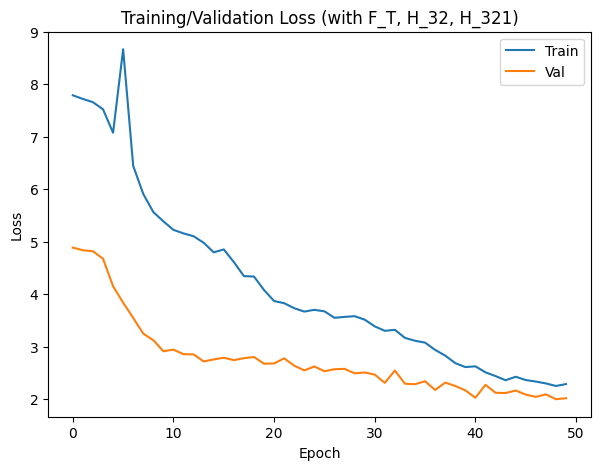

Final Test Loss (Extended VAE): 2.9858


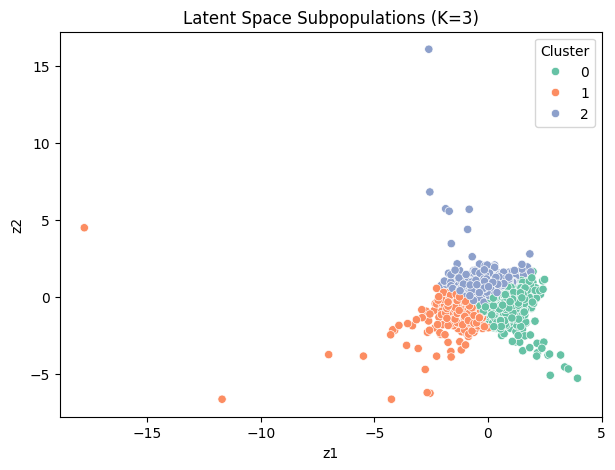

Cluster Membership Counts:
Cluster
0    787
1    252
2    934
Name: count, dtype: int64
Extended pipeline complete. Subpopulation clustering done. Results in 'results_extended' folder.


In [ ]:
"""
Extended VAE Pipeline with Total Fluence (F_T) and Hardness Ratios (H32, H321)
============================================================================

This code snippet shows how to incorporate:
  - F_T = F1 + F2 + F3 + F4
  - H_32 = F3 / F2
  - H_321 = F3 / (F1 + F2)

into our unified deep probabilistic framework. We then cluster the
latent space to reveal potential subpopulations.
"""

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

# 1) CONFIG
OUTPUT_DIR = "results_extended"
os.makedirs(OUTPUT_DIR, exist_ok=True)

SEED = 42
np.random.seed(SEED)
torch.manual_seed(SEED)
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {DEVICE}")

# 2) LOAD DATA
data_path = "BATSE-4Br-dat.csv"  # your actual file path
df = pd.read_csv(data_path)

# 3) CREATE NEW FEATURES: F_T, H_32, H_321
#    We'll handle potential zeros in denominators for hardness ratio
df["F_T"] = df["F1"] + df["F2"] + df["F3"] + df["F4"]

# For hardness ratios, avoid division by zero:
EPS = 1e-14
df["H_32"] = df["F3"] / (df["F2"] + EPS)
df["H_321"] = df["F3"] / (df["F1"] + df["F2"] + EPS)

# 4) SELECT COLUMNS FOR VAE
#    We combine original temporal features plus new ones.
#    E.g.: T50, T90, F_T, H_32, H_321, and possibly P64, P256, P1024
vae_columns = ["T50","T90","F_T","H_32","H_321","P64","P256","P1024"]

# 5) DROP NA ROWS if any
df_model = df.dropna(subset=vae_columns).copy()
print(f"Final shape for extended VAE dataset: {df_model.shape}")

# 6) PREPARE DATA / SPLIT
X_raw = df_model[vae_columns].values
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_raw)

X_train, X_test = train_test_split(X_scaled, test_size=0.2, random_state=SEED)
X_train, X_val  = train_test_split(X_train, test_size=0.2, random_state=SEED)

X_train_tensor = torch.from_numpy(X_train).float()
X_val_tensor   = torch.from_numpy(X_val).float()
X_test_tensor  = torch.from_numpy(X_test).float()

train_loader = DataLoader(TensorDataset(X_train_tensor), batch_size=64, shuffle=True)
val_loader   = DataLoader(TensorDataset(X_val_tensor),   batch_size=64, shuffle=False)
test_loader  = DataLoader(TensorDataset(X_test_tensor),  batch_size=64, shuffle=False)

# 7) DEFINE VAE
class VAE(nn.Module):
    def __init__(self, input_dim=8, latent_dim=2, hidden_dims=[64, 32]):
        super(VAE, self).__init__()

        # Encoder
        encoder_layers = []
        prev_dim = input_dim
        for h in hidden_dims:
            encoder_layers.append(nn.Linear(prev_dim, h))
            encoder_layers.append(nn.ReLU())
            prev_dim = h
        self.encoder = nn.Sequential(*encoder_layers)

        self.mu_layer     = nn.Linear(prev_dim, latent_dim)
        self.logvar_layer = nn.Linear(prev_dim, latent_dim)

        # Decoder
        decoder_layers = []
        rev_hidden = hidden_dims[::-1]
        prev_dim = latent_dim
        for h in rev_hidden:
            decoder_layers.append(nn.Linear(prev_dim, h))
            decoder_layers.append(nn.ReLU())
            prev_dim = h
        self.decoder = nn.Sequential(*decoder_layers)
        self.final_layer = nn.Linear(prev_dim, input_dim)

    def encode(self, x):
        h = self.encoder(x)
        mu = self.mu_layer(h)
        logvar = self.logvar_layer(h)
        return mu, logvar

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps*std

    def decode(self, z):
        h = self.decoder(z)
        return self.final_layer(h)

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        x_recon = self.decode(z)
        return x_recon, mu, logvar

def vae_loss(x, x_recon, mu, logvar):
    recon_loss = nn.functional.mse_loss(x_recon, x, reduction='sum')
    kl_div = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return recon_loss + kl_div

# 8) TRAIN
model = VAE(input_dim=len(vae_columns), latent_dim=2, hidden_dims=[64,32]).to(DEVICE)
optimizer = optim.Adam(model.parameters(), lr=1e-3)

EPOCHS = 50
train_losses, val_losses = [], []

for epoch in range(EPOCHS):
    # ---- train ----
    model.train()
    running_train_loss = 0.0
    for batch in train_loader:
        xb = batch[0].to(DEVICE)
        optimizer.zero_grad()
        x_recon, mu, logvar = model(xb)
        loss = vae_loss(xb, x_recon, mu, logvar)
        loss.backward()
        optimizer.step()
        running_train_loss += loss.item()
    epoch_train_loss = running_train_loss / len(train_loader.dataset)

    # ---- validation ----
    model.eval()
    running_val_loss = 0.0
    with torch.no_grad():
        for batch in val_loader:
            xb = batch[0].to(DEVICE)
            x_recon_val, mu_val, logvar_val = model(xb)
            val_loss = vae_loss(xb, x_recon_val, mu_val, logvar_val)
            running_val_loss += val_loss.item()
    epoch_val_loss = running_val_loss / len(val_loader.dataset)

    train_losses.append(epoch_train_loss)
    val_losses.append(epoch_val_loss)

    if (epoch+1) % 5 == 0:
        print(f"Epoch {epoch+1}/{EPOCHS} | Train Loss: {epoch_train_loss:.4f} | Val Loss: {epoch_val_loss:.4f}")

# PLOT TRAINING CURVE
plt.figure(figsize=(7,5))
plt.plot(train_losses, label="Train")
plt.plot(val_losses, label="Val")
plt.title("Training/Validation Loss (with F_T, H_32, H_321)")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.savefig(os.path.join(OUTPUT_DIR, "training_curve_extended.png"), dpi=300)
plt.show()

# 9) TEST SET EVALUATION
model.eval()
X_test_torch = X_test_tensor.to(DEVICE)
with torch.no_grad():
    x_test_recon, mu_test, logvar_test = model(X_test_torch)
    test_loss_val = vae_loss(X_test_torch, x_test_recon, mu_test, logvar_test).item() / len(X_test)
print(f"Final Test Loss (Extended VAE): {test_loss_val:.4f}")

# 10) LATENT SPACE + CLUSTERING -> REVEAL SUBPOPULATIONS
X_all_scaled = scaler.transform(df_model[vae_columns].values)
X_all_tensor = torch.from_numpy(X_all_scaled).float().to(DEVICE)

with torch.no_grad():
    x_all_recon, mu_all, logvar_all = model(X_all_tensor)
    recon_error_all = torch.mean((x_all_recon - X_all_tensor)**2, dim=1)
    z_all = model.reparameterize(mu_all, logvar_all)

recon_error_all = recon_error_all.cpu().numpy()
z_all = z_all.cpu().numpy()

df_analysis = df_model.copy()
df_analysis["ReconError"] = recon_error_all
df_analysis["z1"] = z_all[:,0]
df_analysis["z2"] = z_all[:,1]

# SUBPOPULATION DETECTION VIA KMeans (for demonstration)
kmeans = KMeans(n_clusters=3, random_state=SEED)  # choose 3, e.g.
labels = kmeans.fit_predict(z_all)
df_analysis["Cluster"] = labels

# SCATTER PLOT LATENT SPACE COLORED BY CLUSTER
plt.figure(figsize=(7,5))
sns.scatterplot(x="z1", y="z2", hue="Cluster", data=df_analysis, palette="Set2")
plt.title("Latent Space Subpopulations (K=3)")
plt.savefig(os.path.join(OUTPUT_DIR, "latent_space_clusters_extended.png"), dpi=300)
plt.show()

# 11) INSPECT CLUSTERS
cluster_counts = df_analysis["Cluster"].value_counts().sort_index()
print("Cluster Membership Counts:")
print(cluster_counts)

# SAVE RESULTS
df_analysis.to_csv(os.path.join(OUTPUT_DIR, "df_analysis_extended.csv"), index=False)
cluster_counts.to_csv(os.path.join(OUTPUT_DIR, "cluster_counts_extended.csv"))

print("Extended pipeline complete. Subpopulation clustering done. Results in 'results_extended' folder.")
